In [48]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
#from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))


def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        if config.sin_space_scale == 4.:
            ts_type_str = "fQuadSinHF1"
        else:
            ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(
        np.float64)  #np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"MSE {round(rmse, 6)} for MLP Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        if "_ST_" in config.scoreNet_trained_path:
            plt.savefig((
                            f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
        else:
            plt.savefig((
                            f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 0
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.95   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [50]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

0.0
Using CPU



In [51]:
(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss").replace("GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/", "Desktop/RetrySinLog/")

'/Users/marcos/Desktop/RetrySinLog/trained_rec_ST_0002FTh_PM_MLP_2LFac_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_MLP_H4_CUp20_tl110_loss'

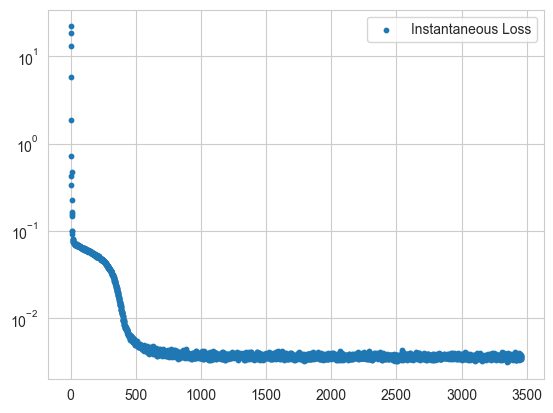

3459

In [52]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
Nepochs_losses[-1]

In [53]:
np.mean(losses[3000:])

0.0035960825392976404

In [54]:
Nepochs_losses

array([   0,    1,    2, ..., 3457, 3458, 3459])

0.003484372129974384 0.003527149255927943
0.0036059830838304414


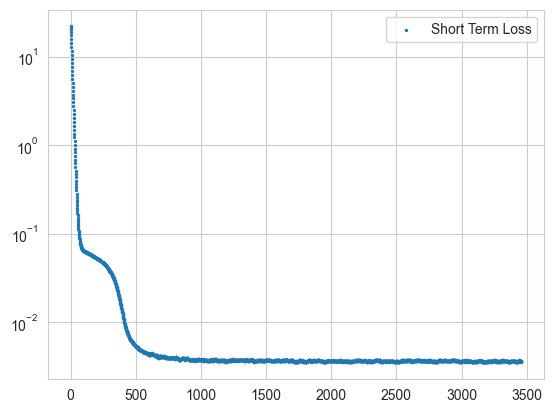

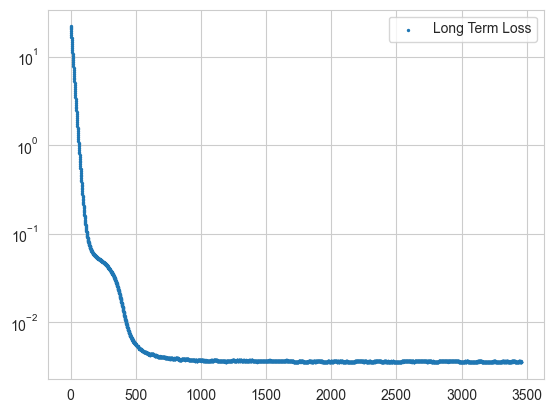

In [55]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

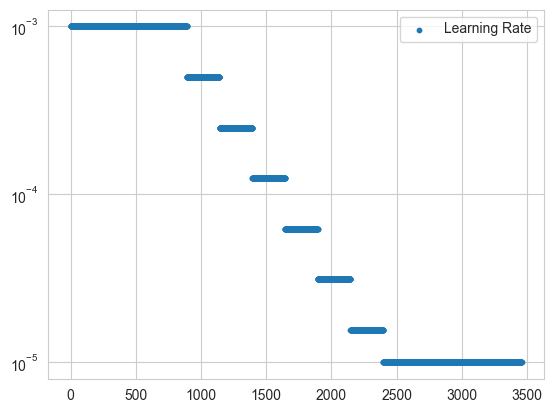

0
[1.e-03 1.e-03 1.e-03 ... 1.e-05 1.e-05 1.e-05]


In [56]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)
print(LRs)

In [57]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    if config.sin_space_scale == 25.:
        ts_type = "fQuadSin2"
    else:
        ts_type = "fQuadSin1"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
maxx = -minx
print(ts_type, include)

fBiPot 3906e-03dT_025a_-05b_00c


In [58]:
def get_drift_files(config, include, ts_type_str):
    ts_type = f"{ts_type_str}"
    if "BiPot" in ts_type_str:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                    ".", "")
    elif "QuadSin" in ts_type_str:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}").replace(
                ".", "")
    root_score_dir = root_dir + f"ExperimentsResults/TSPM_Markovian/4DLnz/"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP" in file and ts_type in file and include in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "local" in file:
                    driftoostrack_local_files.append(root_score_dir+file)
    #assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    #assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert len(driftevalexp_files)>0, "No eval exp files found"
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [59]:
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fBiPot".replace(".", "")
    else:
        ts_type_str = "fBiPot"
elif "QuadSinHF" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fQuadSinHF".replace(".","")
    else:
        ts_type_str = "fQuadSinHF"
elif "SinLog" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fSinLog".replace(".","")
    else:
        ts_type_str = "fSinLog"

print(ts_type_str)
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, include=include, ts_type_str=ts_type_str)

ST_0002FTh_fBiPot


In [60]:
driftevalexp_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_MLP_ST_0002FTh_fBiPot_DriftEvalExp_4Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_MLPWAttn_ST_0002FTh_fBiPot_DriftEvalExp_4Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_MLPWAttn_ST_0002FTh_fBiPot_DriftEvalExp_8Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_MLPWAttn_ST_0002FTh_fBiPot_DriftEvalExp_10Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_MLP_ST_0002FTh_fBiPot_DriftEvalExp_10Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy',
 '/Users/marcos/GitHubRepos/Fract

In [61]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 4)})
    except pickle.UnpicklingError as e:
        continue
    except [FileNotFoundError] as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{4: 2.5943,
 8: 0.4245,
 10: 0.3845,
 14: 0.4881,
 18: 0.3214,
 20: 0.3543,
 24: 0.3237,
 28: 0.3048,
 30: 0.2993,
 34: 0.3977,
 38: 0.276,
 40: 0.3937,
 44: 0.2166,
 48: 0.1732,
 50: 0.1435,
 54: 0.3135,
 58: 0.0492,
 60: 0.0346,
 64: 0.2679,
 68: 0.0227,
 70: 0.2504,
 74: 0.0137,
 78: 0.0397,
 80: 0.1843,
 84: 0.0343,
 88: 0.0355,
 90: 0.0479,
 94: 0.0716,
 98: 0.0325,
 100: 0.0324,
 104: 0.0157,
 108: 0.0463,
 110: 0.0675,
 114: 0.0212,
 118: 0.0404,
 120: 0.0369,
 124: 0.0335,
 128: 0.4168,
 130: 0.0393,
 134: 0.0336,
 138: 0.0359,
 140: 0.0354,
 144: 0.0319,
 148: 0.2484,
 150: 0.0339,
 154: 0.0324,
 158: 0.0903,
 160: 0.1946,
 164: 0.3695,
 168: 0.0325,
 170: 0.0389,
 174: 0.3851,
 178: 0.0246,
 180: 0.0638,
 184: 0.0945,
 188: 1.3445,
 190: 0.0902,
 194: 0.0688,
 198: 0.0221,
 200: 0.0699,
 204: 0.0979,
 208: 0.0853,
 210: 0.0541,
 214: 0.0274,
 218: 0.2267,
 220: 0.0852,
 224: 0.0236,
 228: 0.142,
 230: 0.0213,
 234: 0.1145,
 238: 0.0131,
 240: 0.0651,
 244: 0.0293,
 248: 0.053

In [62]:
try:
    print(eval_exp_rmses[Nepochs_losses[np.argmin(losses)]-1], Nepochs_losses[np.argmin(losses)]-1)
except KeyError:
    pass
try:
    print(eval_exp_rmses[Nepochs_losses[np.argmin(losses)]], Nepochs_losses[np.argmin(losses)])
except KeyError:
    pass
try:
    print(eval_exp_rmses[Nepochs_losses[np.argmin(losses)]+1], Nepochs_losses[np.argmin(losses)]+1)
except KeyError:
    pass

In [63]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_states= np.load(local,allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        continue
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()
drift_track_rmses

[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/.TSPM_MLPWAttn_ST_0002FTh_fBiPot_OOSDriftTrack_3818Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy.Fxlzwc'


{4: 245.76099089133103,
 10: 245.6234805972134,
 14: 0.012172177778551865,
 18: 0.0012182793812230601,
 20: 0.001247064729021907,
 24: 252.11588145281485,
 28: 0.001085135301705759,
 30: 239.10074603874472,
 34: 0.0011703700190446322,
 40: 0.0014587449140273123,
 44: 248.9325198397434,
 50: 231.53369724927742,
 54: 0.0004795939497837153,
 60: 0.0002820442674023044,
 64: 242.609448834725,
 70: 235.61158458706979,
 74: 0.0009482683553982843,
 80: 234.0252549239695,
 84: 0.0008143257808491738,
 90: 0.00021997289215350166,
 94: 252.2072283154138,
 100: 240.23307989751225,
 104: 0.0003173064751540968,
 108: 0.00027048220524118234,
 110: 235.52234870784065,
 114: 0.00017555681433798208,
 118: 0.0002297166408663402,
 120: 244.32160547884823,
 124: 0.00017839912471586376,
 128: 0.0016988426772498704,
 130: 244.18055715495979,
 134: 0.00018189119463242885,
 138: 0.0002070041531029321,
 140: 229.12067133240348,
 144: 0.0002427603810459589,
 148: 0.0009828068881722809,
 150: 251.7903298221341,
 1

In [64]:
common_epochs = np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), np.arange(50, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = evalexp_idx#[np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = eval_rmses#np.array(list(drift_track_rmses.values()))[track_idx]

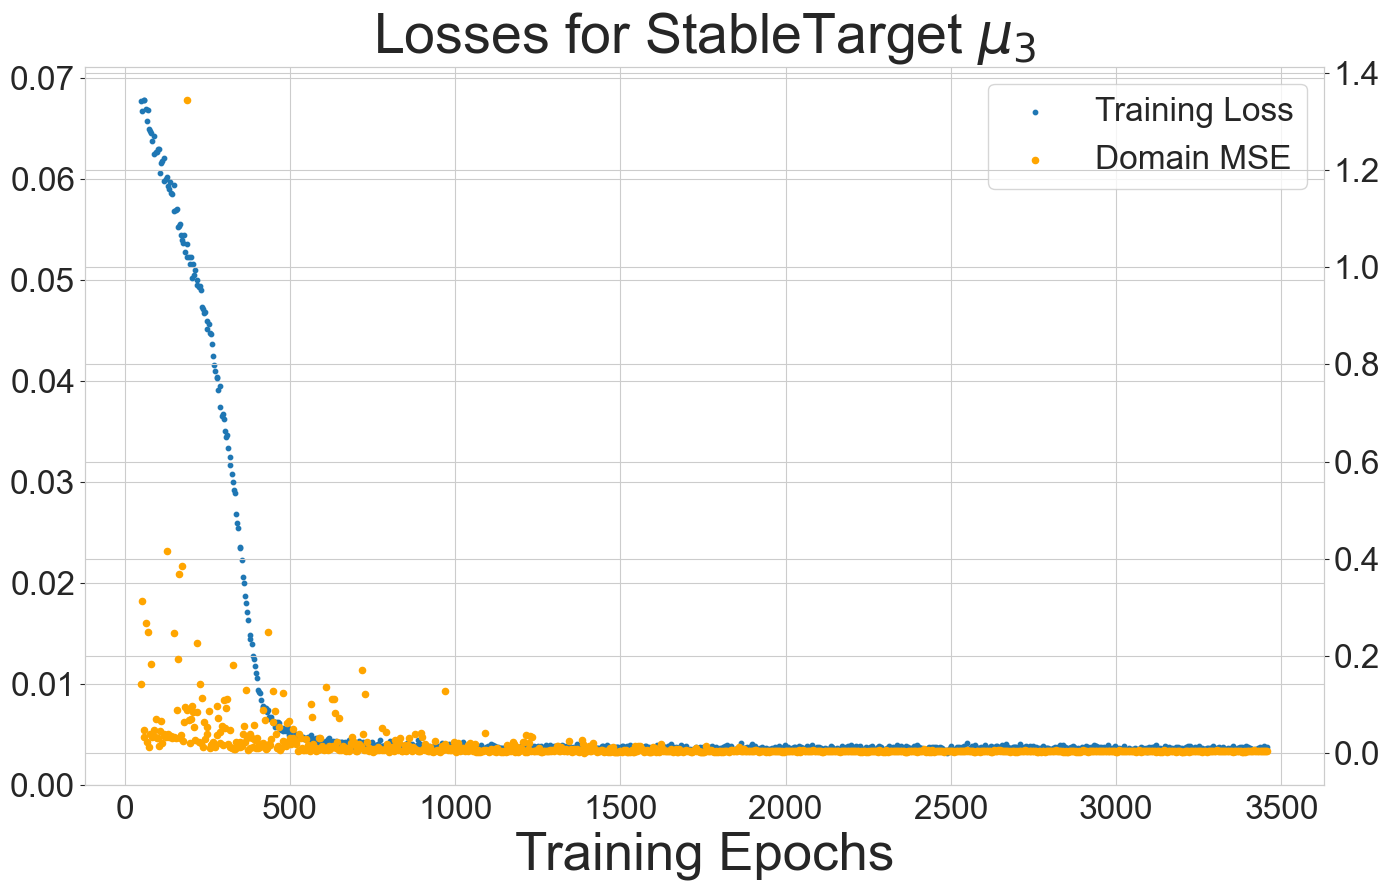

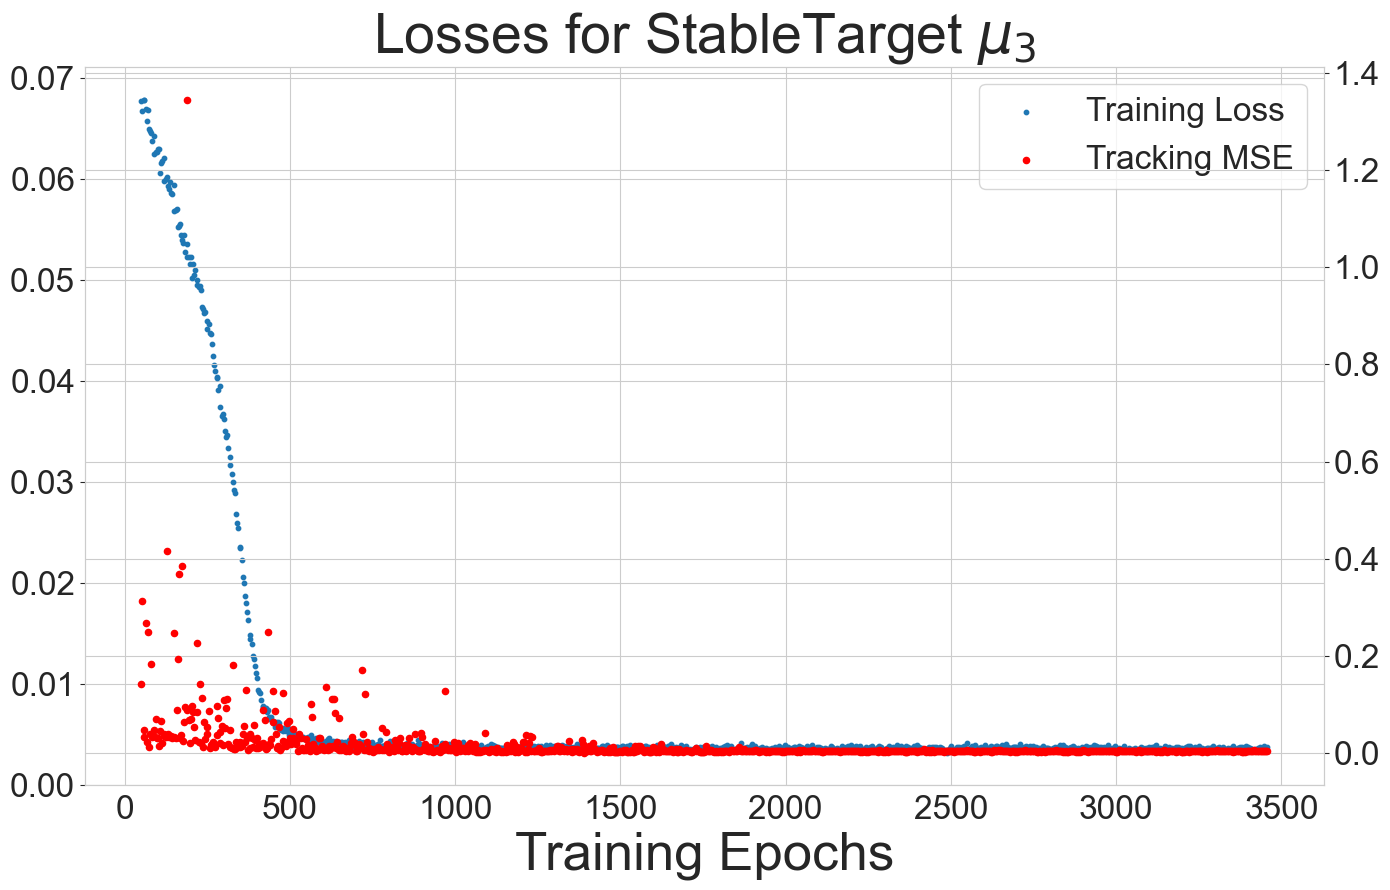

In [65]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)
if "SinLog" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{1}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{2}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{4}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "_ST_" in config.scoreNet_trained_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    else:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)

elif "SinLog" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{1}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{2}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{4}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "_ST_" in config.scoreNet_trained_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    else:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

0.0035147563961963803 0.0035508263345582596
0.003583153768212776


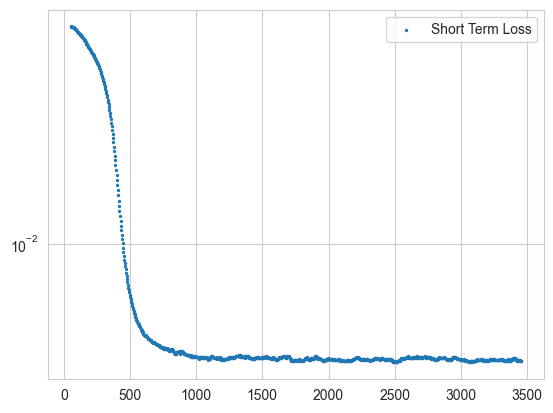

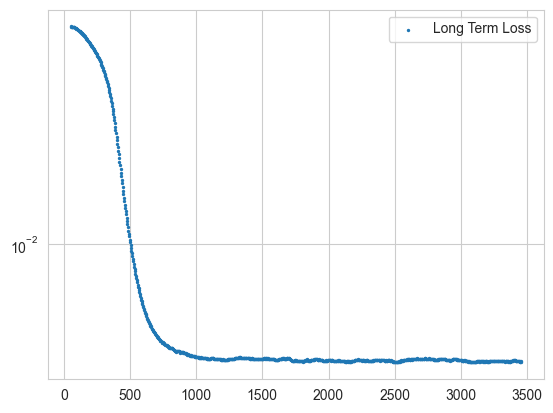

In [66]:
plot_ewma_losses(epochs=common_epochs, losses=red_losses)

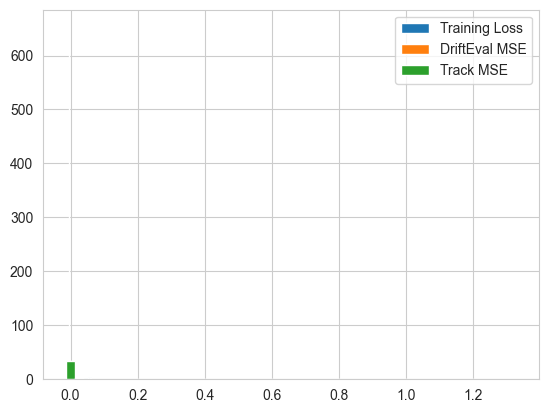

In [67]:
mean0_red_losses = (red_losses - np.mean(red_losses))#/np.std(red_losses)
mean0_track_rmses = (track_rmses - np.mean(track_rmses))#/np.std(track_rmses)
mean0_eval_rmses = (eval_rmses - np.mean(eval_rmses))#/np.std(eval_rmses)
plt.hist(mean0_red_losses, bins=50, density=True, label="Training Loss")
plt.hist(mean0_eval_rmses, bins=50, density=True,label="DriftEval MSE")
plt.hist(mean0_track_rmses, bins=50, density=True,label="Track MSE")
plt.legend()
plt.show()
plt.close()

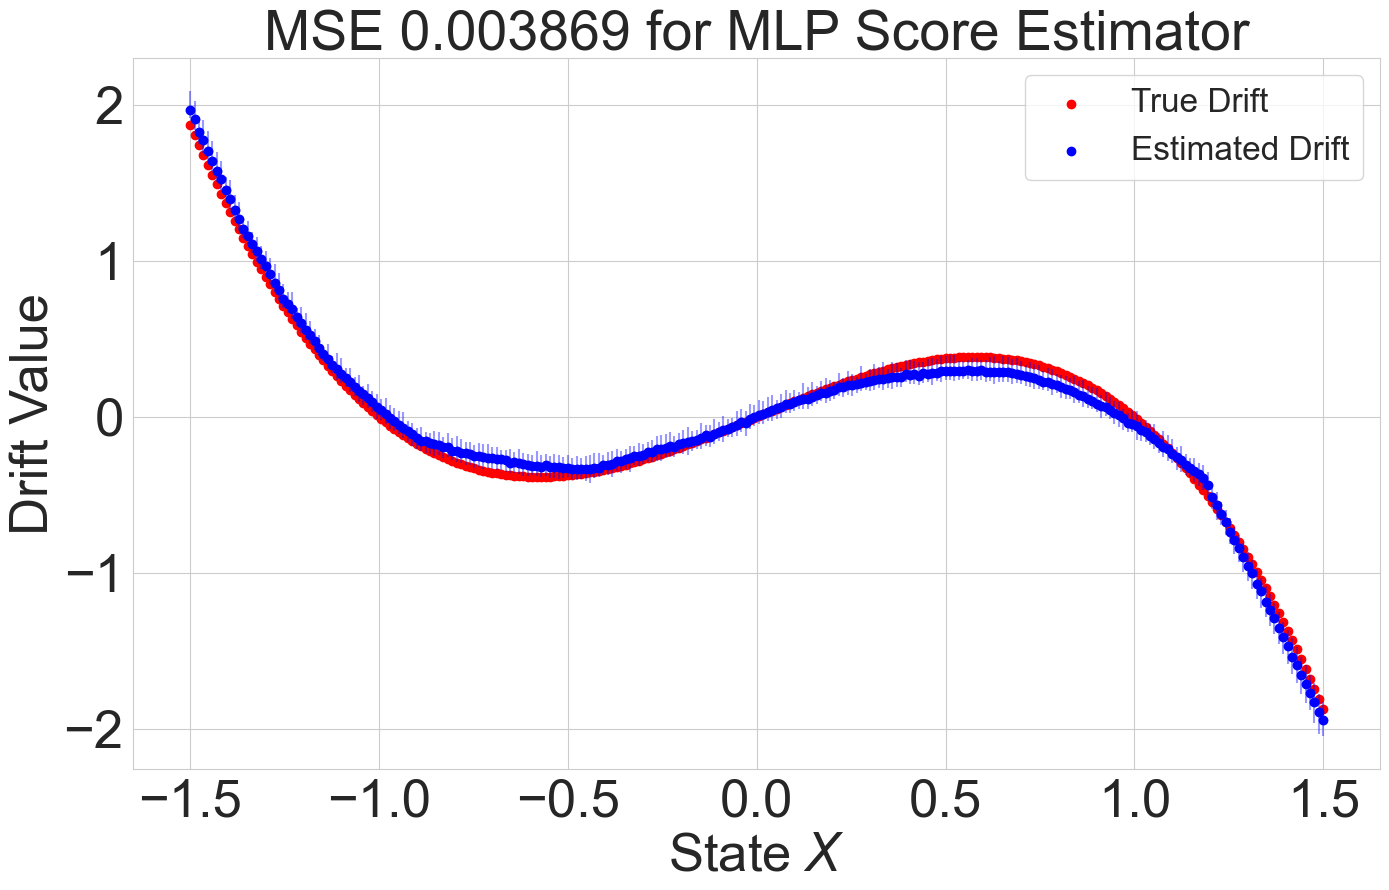

MSE  0.003869015723466873 with IQR ((array([ 1.9178711 ,  1.8425293 ,  1.75      ,  1.6953125 ,  1.6424805 ,
        1.5800781 ,  1.5064942 ,  1.4570312 ,  1.3954589 ,  1.3319336 ,
        1.2665527 ,  1.2077637 ,  1.1493652 ,  1.1015625 ,  1.0533692 ,
        0.99609375,  0.9511719 ,  0.9032715 ,  0.85249025,  0.8027344 ,
        0.75874025,  0.7000488 ,  0.66796875,  0.6269531 ,  0.5799805 ,
        0.5388672 ,  0.49589843,  0.4647461 ,  0.4276367 ,  0.390625  ,
        0.35546875,  0.30839843,  0.27929688,  0.23520508,  0.21967773,
        0.19213867,  0.16293946,  0.13671875,  0.09663086,  0.07709961,
        0.05952149,  0.02919922, -0.01274414, -0.02075195, -0.04296875,
       -0.07480469, -0.09282227, -0.10649414, -0.13784179, -0.15830079,
       -0.18461914, -0.203125  , -0.21782227, -0.23046875, -0.23828125,
       -0.2529785 , -0.2421875 , -0.2616455 , -0.25390625, -0.27753907,
       -0.28720704, -0.29594725, -0.30961913, -0.30524904, -0.328125  ,
       -0.32133788, -0.3323

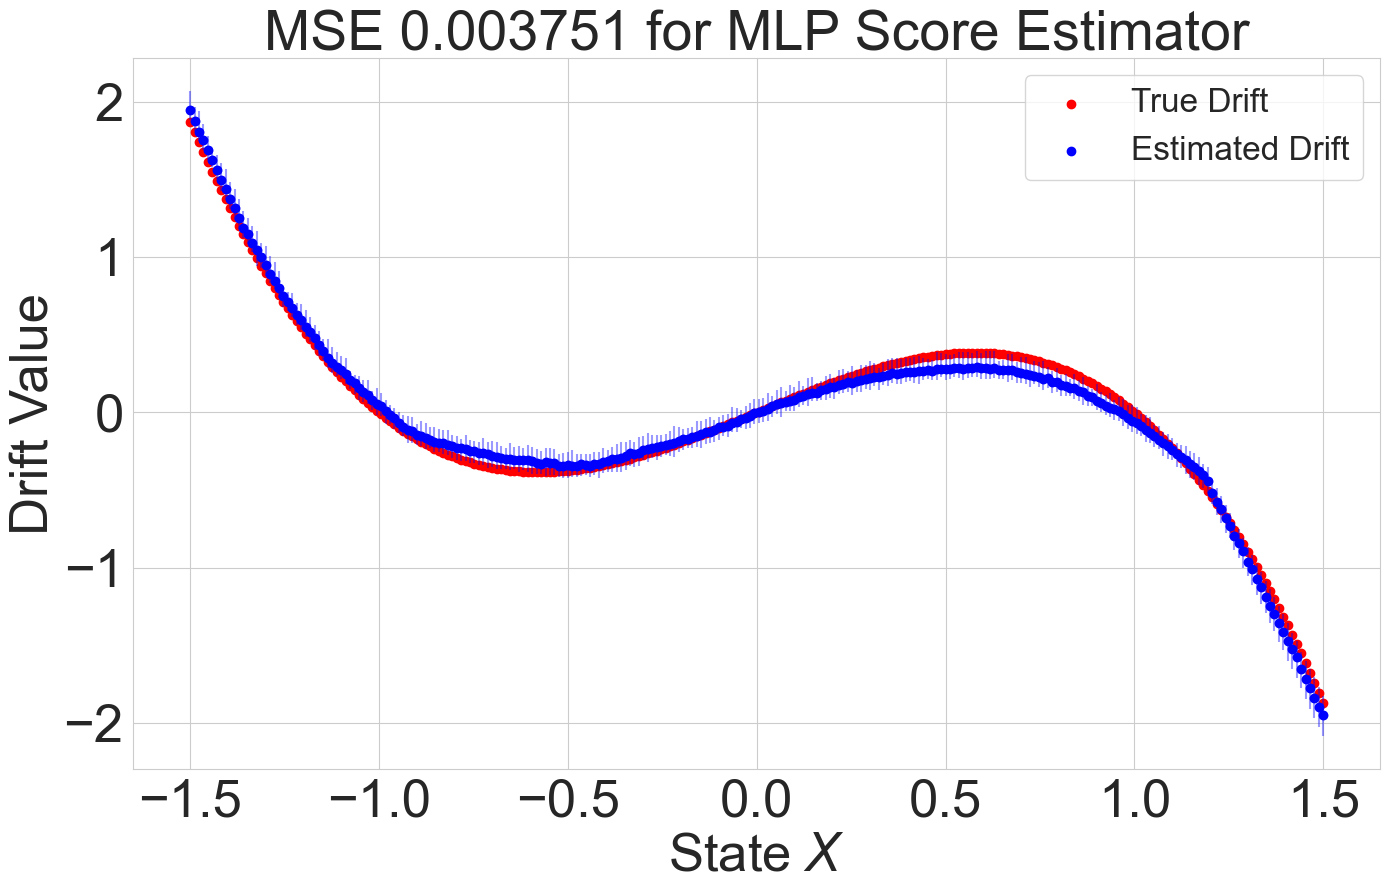

MSE  0.0037511740811169147 with IQR ((array([ 1.8817871 ,  1.8123047 ,  1.75      ,  1.6903808 ,  1.6239746 ,
        1.5810058 ,  1.5043457 ,  1.4283692 ,  1.3718262 ,  1.3085938 ,
        1.238086  ,  1.1835938 ,  1.1268555 ,  1.0849121 ,  1.0311524 ,
        0.94453126,  0.9334961 ,  0.8777832 ,  0.8359375 ,  0.7927734 ,
        0.739209  ,  0.68061525,  0.6532715 ,  0.61513674,  0.56640625,
        0.53125   ,  0.489209  ,  0.45478517,  0.40112305,  0.36606446,
        0.33491212,  0.286084  ,  0.25390625,  0.234375  ,  0.21464844,
        0.18061523,  0.1484375 ,  0.12202148,  0.07792969,  0.06435547,
        0.05263672,  0.01728516, -0.01367188, -0.0234375 , -0.07421875,
       -0.07626953, -0.10751953, -0.13476562, -0.1496582 , -0.19550781,
       -0.19550781, -0.20908204, -0.21689454, -0.234375  , -0.22851562,
       -0.25307617, -0.2578125 , -0.26953125, -0.2754883 , -0.2911133 ,
       -0.3071289 , -0.31445312, -0.31352538, -0.32626954, -0.32421875,
       -0.33984375, -0.337

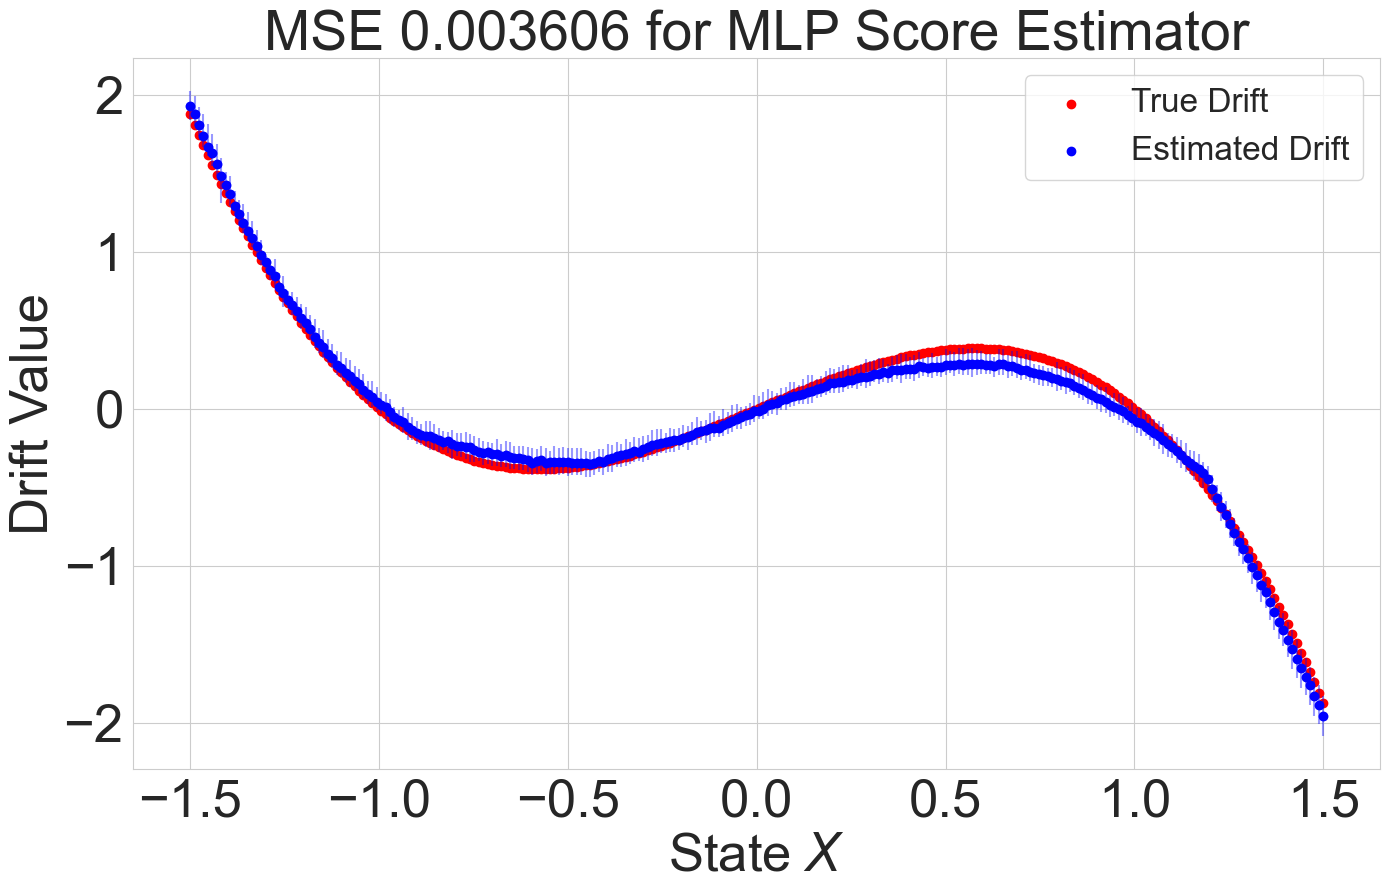

MSE  0.0036056190729141235 with IQR ((array([ 1.83964849e+00,  1.80263674e+00,  1.73725581e+00,  1.66552734e+00,
        1.61030269e+00,  1.54780269e+00,  1.48334956e+00,  1.30859375e+00,
        1.35527349e+00,  1.29238284e+00,  1.23334956e+00,  1.16181636e+00,
        1.11914062e+00,  1.07670903e+00,  1.03022456e+00,  9.70703125e-01,
        9.16845679e-01,  8.75000000e-01,  8.22265625e-01,  7.82177746e-01,
        7.15673804e-01,  6.48046851e-01,  6.40625000e-01,  5.96630871e-01,
        5.57470679e-01,  5.06787121e-01,  4.86230463e-01,  4.43261713e-01,
        3.88574213e-01,  3.53417963e-01,  3.26171875e-01,  2.93896496e-01,
        2.59765625e-01,  2.12597653e-01,  1.98193356e-01,  1.61083981e-01,
        1.37451172e-01,  1.16162106e-01,  9.66308564e-02,  5.94238304e-02,
        3.10546886e-02,  1.04003921e-02, -1.17187500e-02, -3.12500000e-02,
       -7.57324174e-02, -9.39453095e-02, -1.15722656e-01, -1.36718750e-01,
       -1.56250000e-01, -1.99609369e-01, -2.00341791e-01, -2.2

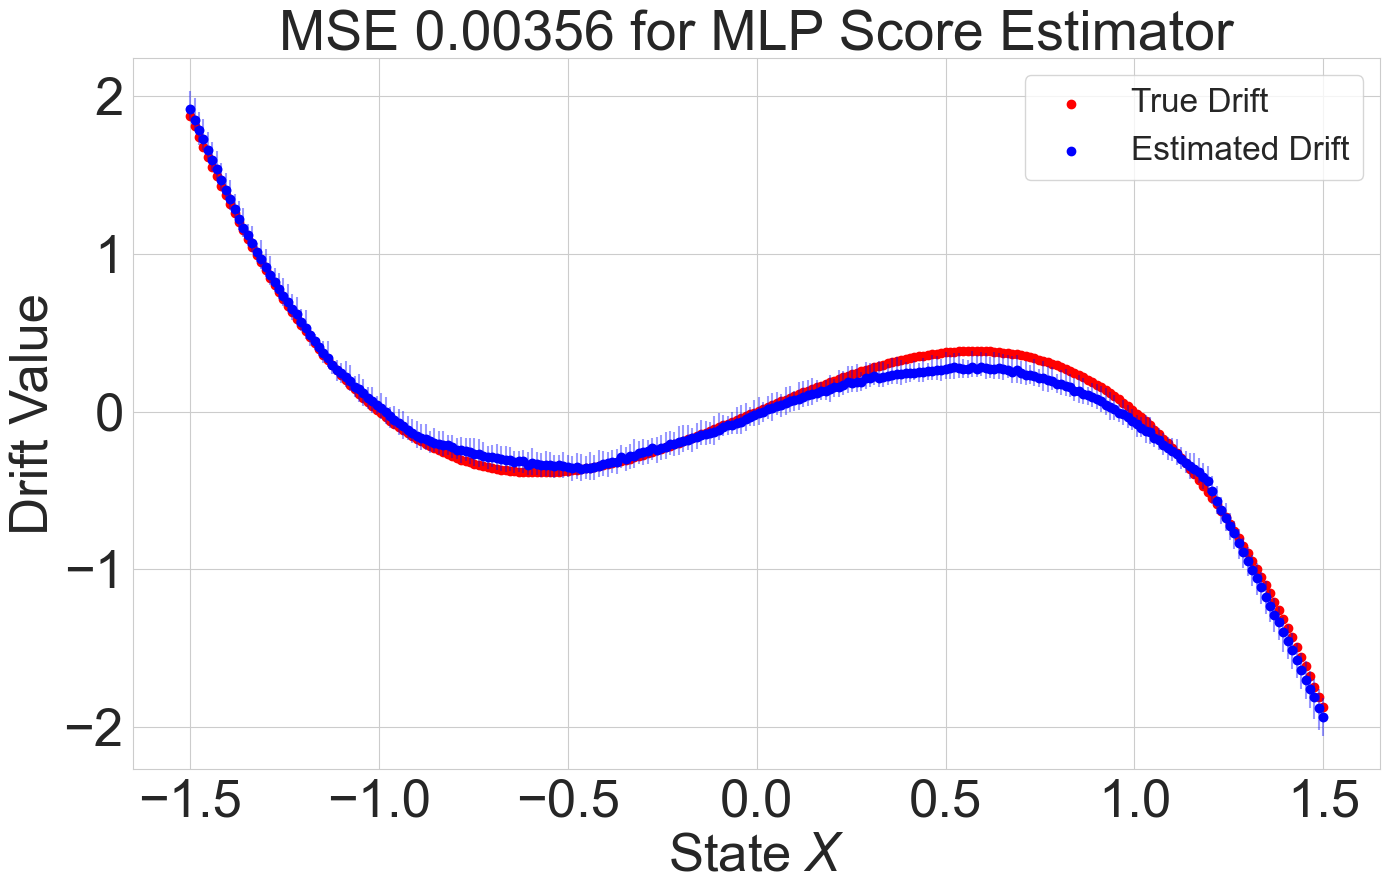

MSE  0.0035604345612227917 with IQR ((array([ 1.8505371e+00,  1.7802246e+00,  1.6912110e+00,  1.6607910e+00,
        1.6042480e+00,  1.5262207e+00,  1.4754394e+00,  1.4032714e+00,
        1.3437500e+00,  1.2810547e+00,  1.2303711e+00,  1.1542969e+00,
        1.1054688e+00,  1.0527344e+00,  1.0115235e+00,  9.5107424e-01,
        9.0122068e-01,  8.5341799e-01,  8.0058593e-01,  7.5781250e-01,
        7.1279299e-01,  6.7187500e-01,  6.2871093e-01,  5.8276367e-01,
        5.4975587e-01,  5.0874025e-01,  4.6289062e-01,  4.1674805e-01,
        3.9145508e-01,  3.5546875e-01,  3.1147462e-01,  2.8125000e-01,
        2.3623046e-01,  1.9531250e-01,  1.7866211e-01,  1.5327148e-01,
        1.3374023e-01,  9.1503911e-02,  6.0449220e-02,  3.2910157e-02,
        1.6552735e-02, -8.8378899e-03, -1.6650390e-02, -4.5117185e-02,
       -7.5341798e-02, -1.0361328e-01, -1.0937500e-01, -1.4555664e-01,
       -1.7309570e-01, -1.7968750e-01, -2.0126954e-01, -2.2963867e-01,
       -2.4526367e-01, -2.4033204e-01, 

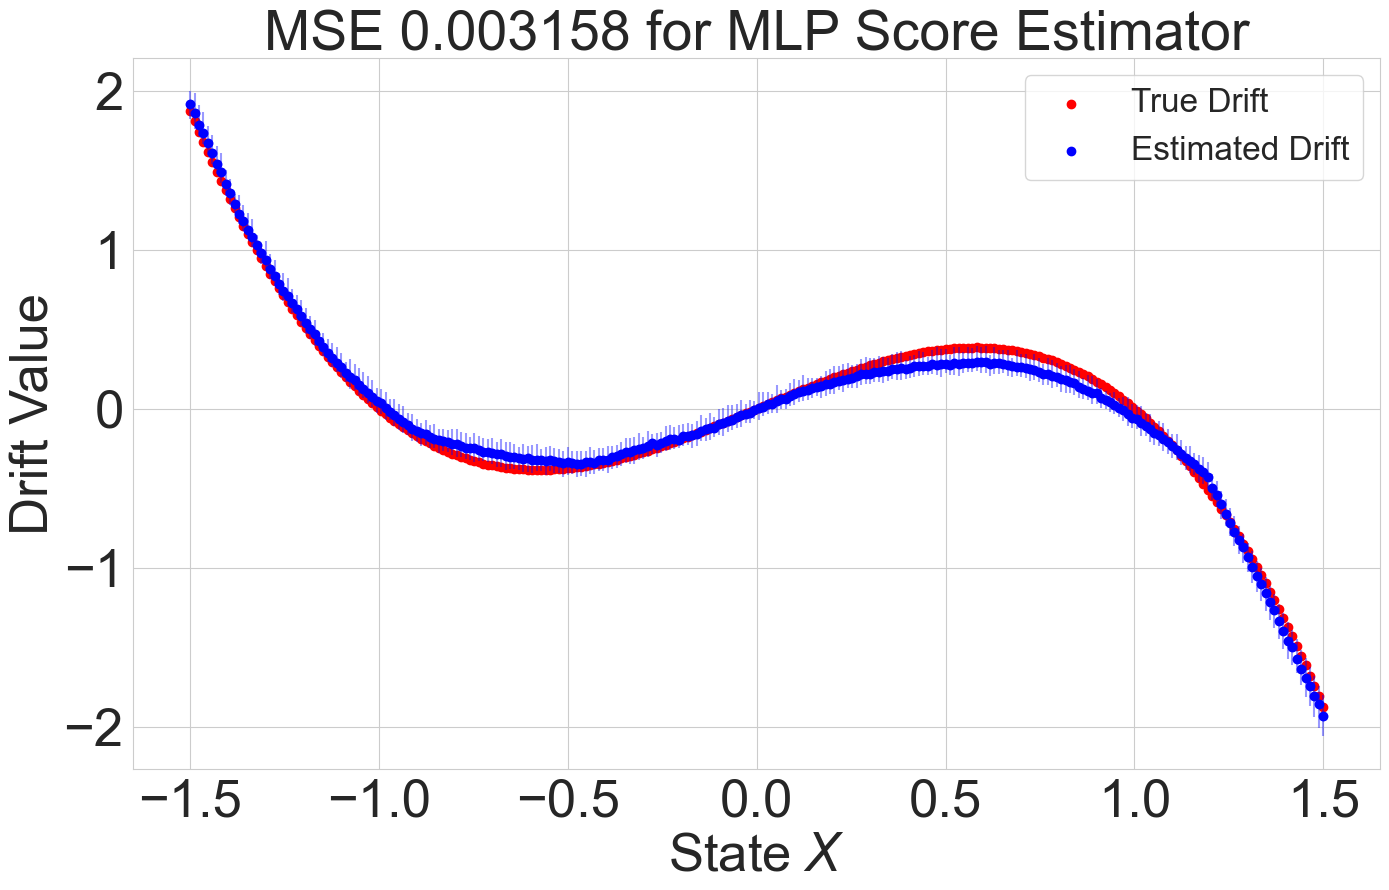

MSE  0.0031577255576848984 with IQR ((array([ 1.82402349e+00,  1.76152349e+00,  1.71518552e+00,  1.66201174e+00,
        1.59428716e+00,  1.53906250e+00,  1.47656250e+00,  1.41879880e+00,
        1.33593750e+00,  1.28085935e+00,  1.22749019e+00,  1.16303706e+00,
        1.11616206e+00,  1.06835938e+00,  1.01635742e+00,  9.64843750e-01,
        9.12109375e-01,  8.69140625e-01,  8.18261743e-01,  7.73437500e-01,
        7.16699243e-01,  6.77539051e-01,  6.47412121e-01,  6.00537121e-01,
        5.70117176e-01,  5.21484375e-01,  4.71630871e-01,  4.39355463e-01,
        3.96191418e-01,  3.80761713e-01,  3.32861334e-01,  2.91943371e-01,
        2.59667963e-01,  2.28515625e-01,  1.94921881e-01,  1.68701172e-01,
        1.22753911e-01,  1.20068356e-01,  8.76953155e-02,  6.53808564e-02,
        3.48632820e-02,  9.66796931e-03, -2.44628899e-02, -3.12500000e-02,
       -6.84570298e-02, -7.22656250e-02, -1.05859369e-01, -1.33105472e-01,
       -1.53564453e-01, -1.67138666e-01, -2.01269537e-01, -2.0

In [70]:
best_rmse = np.inf
toSave = False
for Nepoch in common_epochs:
    try:
        if Nepoch < 3000: raise FileNotFoundError
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""

        if "fQuadSinHF" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_MLP_ST_{config.feat_thresh:.3f}FTh_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                                ".", "")
            else:
                file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_MLP_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                                ".", "")
        elif "fBiPot" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_MLP_ST_{config.feat_thresh:.3f}FTh_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                        ".", "")
            else:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_MLP_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                        ".", "")
        elif "fSinLog" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_MLP_ST_{config.feat_thresh:.3f}FTh_fSinLog_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                        ".", "")
            else:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_MLP_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_").replace(
                        ".", "")
        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        elif "fSinLog" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fSinLog"
        if type == "":
            type="Standard"
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
        elif "SinLog" in config.data_path:
            true_drifts =  -np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale
            #true_drifts = true_drifts/(1.+config.deltaT*torch.abs(true_drifts))
        muhats =  muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1)
        mu_hats = muhats.mean(dim=-1).numpy() # Pointwise drift estimate
        mu_hats_minq = muhats.quantile(dim=-1, q=0.025).numpy() # Lower bound
        mu_hats_maxq = muhats.quantile(dim=-1, q=0.975).numpy() # Lower bound
        stds = muhats.std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts.numpy(), mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts.numpy(), Nepoch=Nepoch)
            print(f"MSE  {rmse} with IQR ({mu_hats_minq, mu_hats_maxq})at Nepoch {Nepoch}\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(e)
        continue

246.21818925439197 45.12744277232122 inf 0
245.76099089133103 44.54297297628068 inf 1


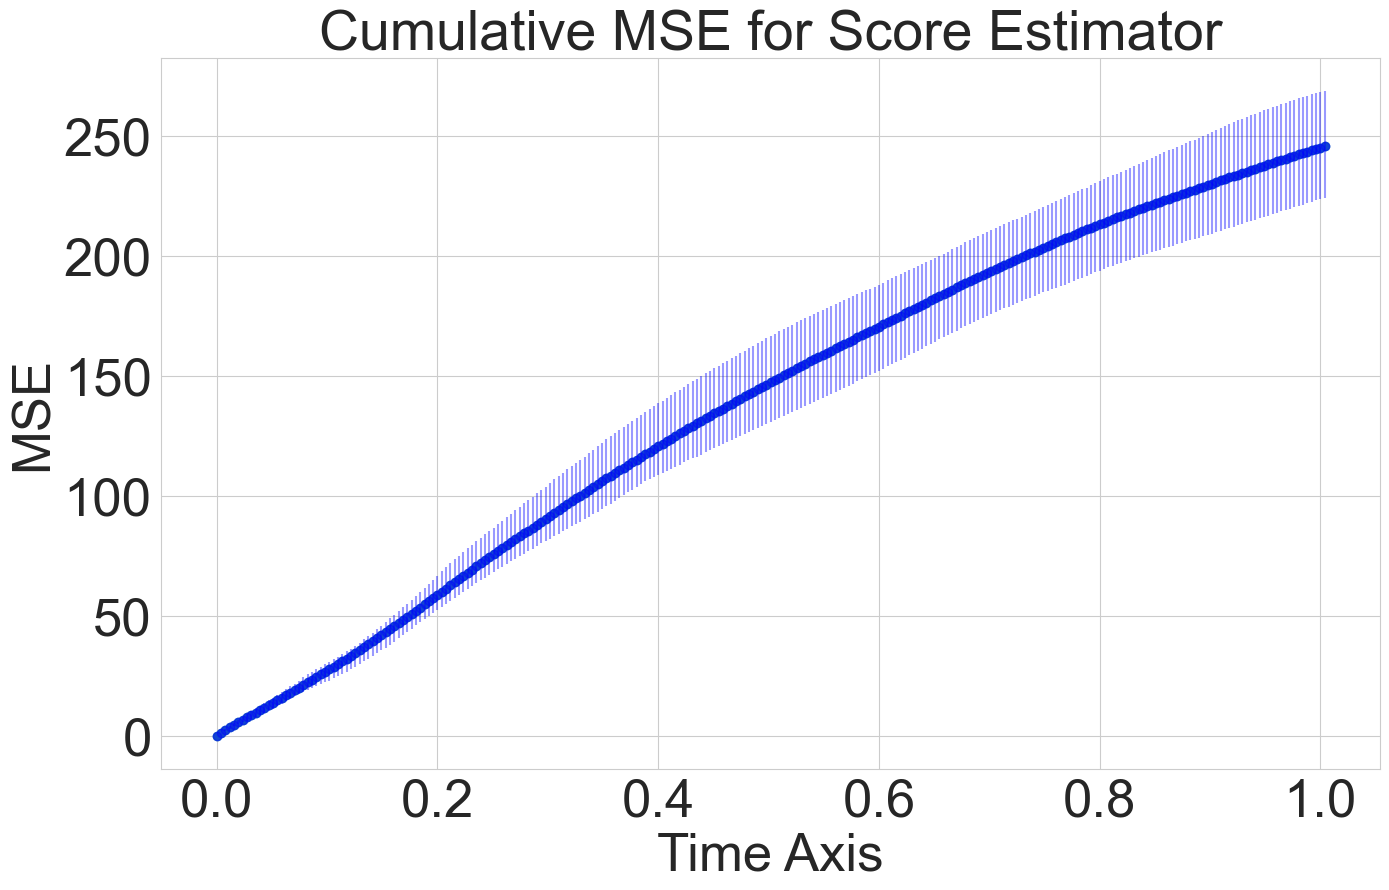

Final time cumulative MSE local-time error 245.76099089133103 with IQR ((224.37889218790997, 268.92186516419065))at Nepoch 54

245.64793405830474 65.27920362582083 245.76099089133103 2


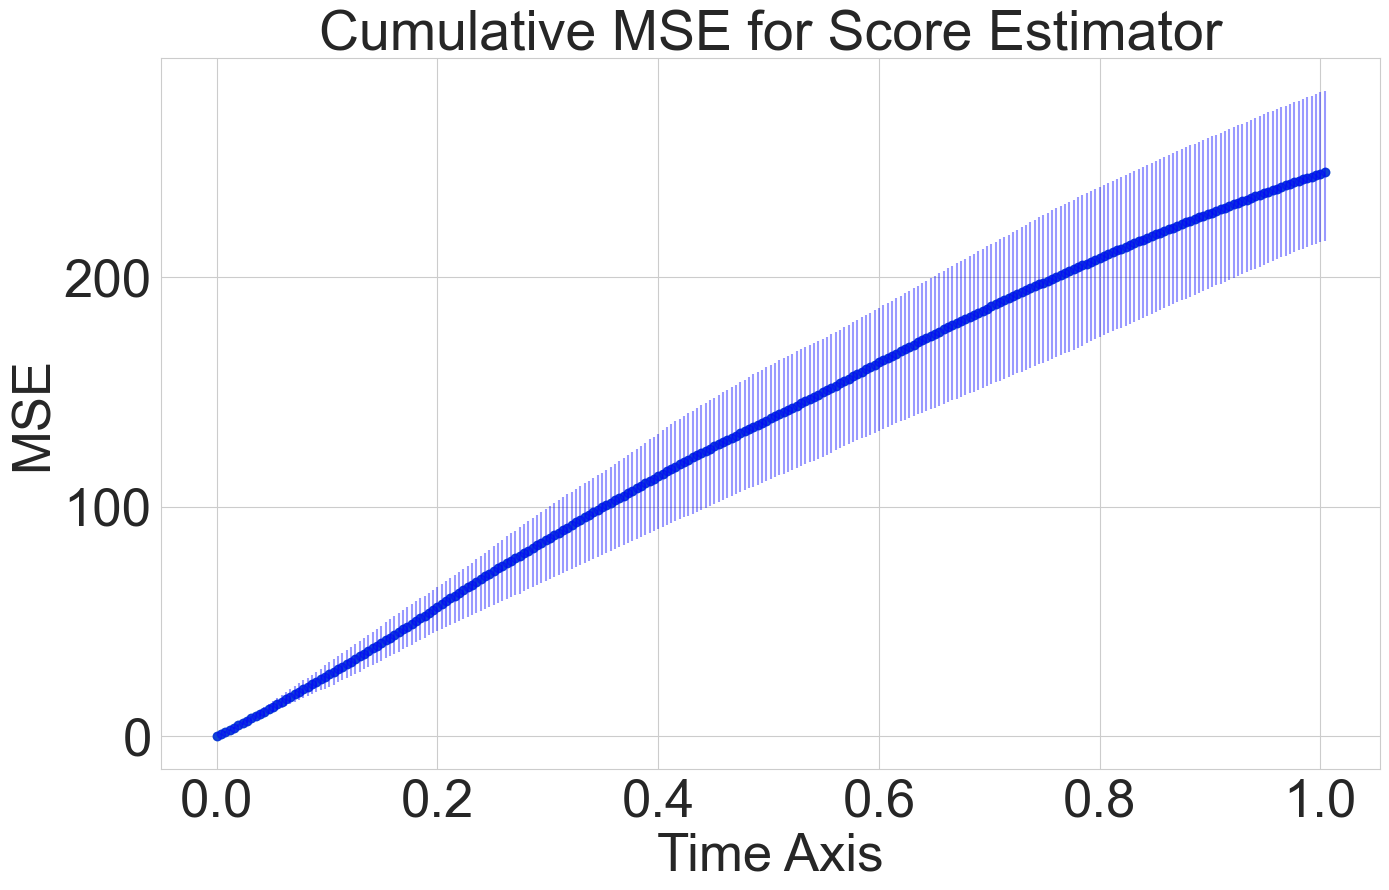

Final time cumulative MSE local-time error 245.64793405830474 with IQR ((215.89699877205314, 281.17620239787396))at Nepoch 58

245.6234805972134 65.24253723001269 245.64793405830474 3


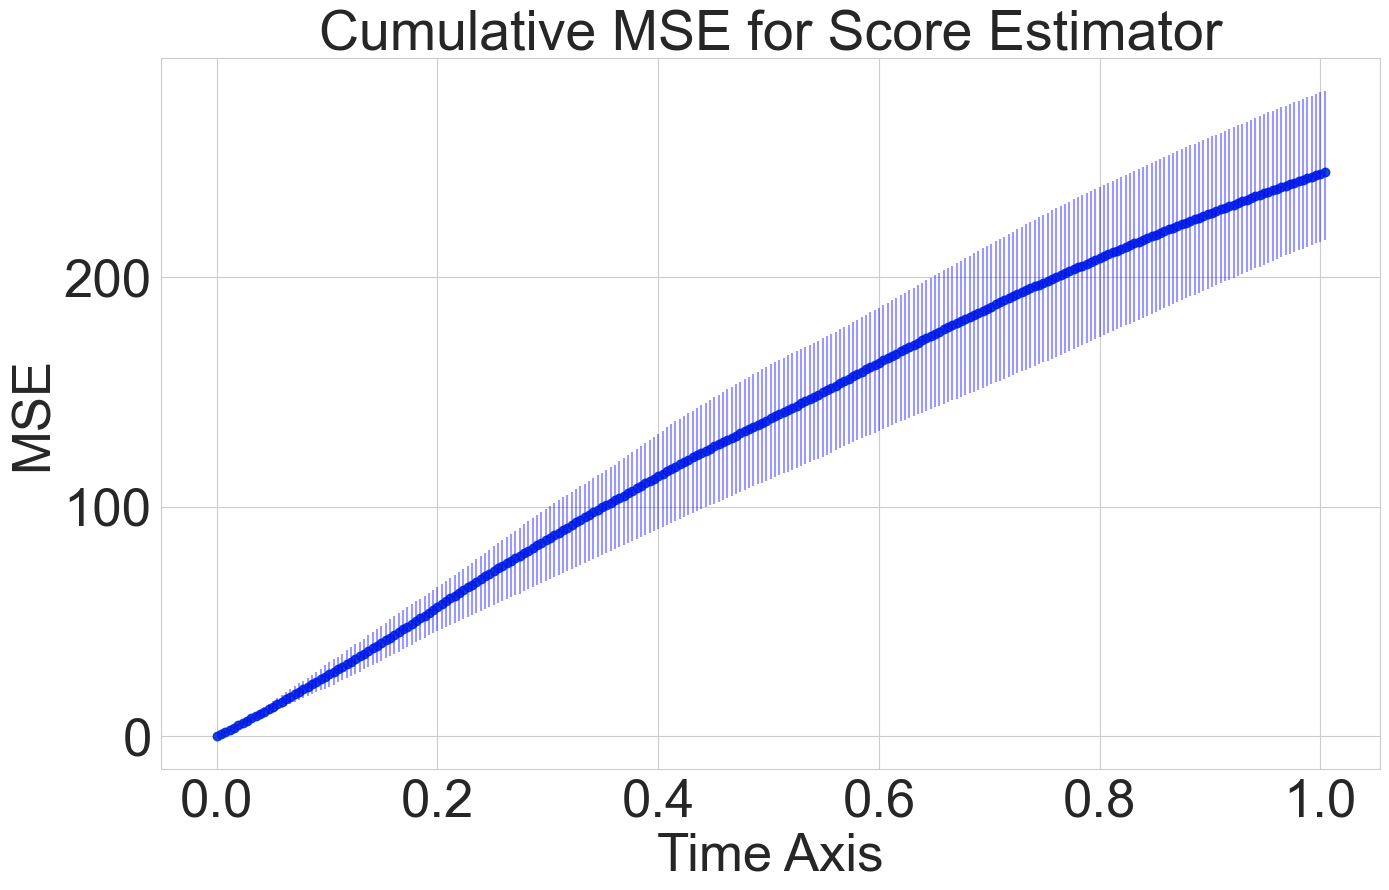

Final time cumulative MSE local-time error 245.6234805972134 with IQR ((215.95639428100176, 281.19893151101445))at Nepoch 60

0.0018687219454180334 0.0005649349026618882 245.6234805972134 4


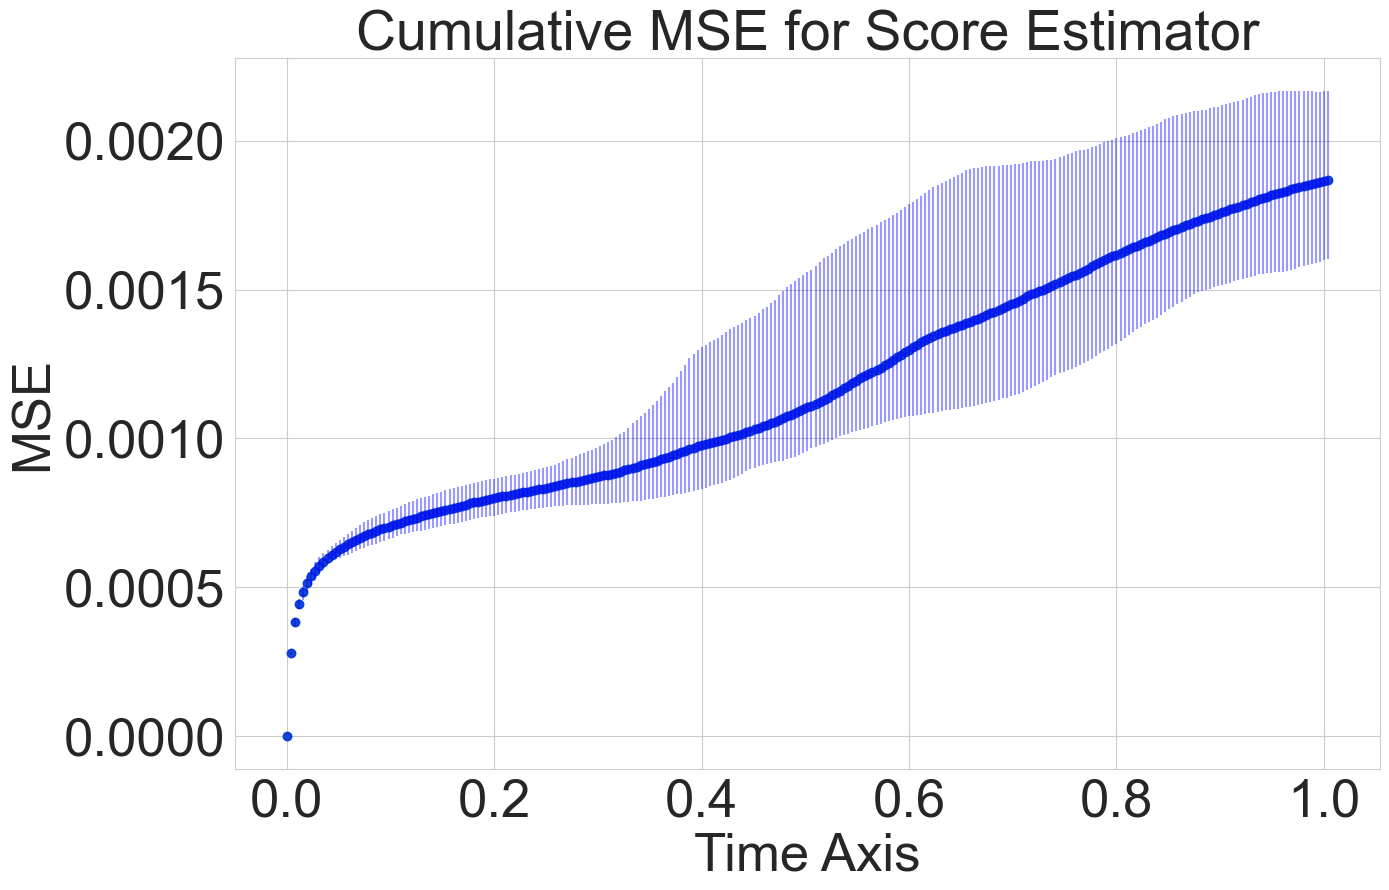

Final time cumulative MSE local-time error 0.0018687219454180334 with IQR ((0.0016026958595415448, 0.002167630762203433))at Nepoch 64

0.012172177778551865 0.0013554980687867767 0.0018687219454180334 5
0.0012182793812230601 0.0005026964257047688 0.0018687219454180334 6


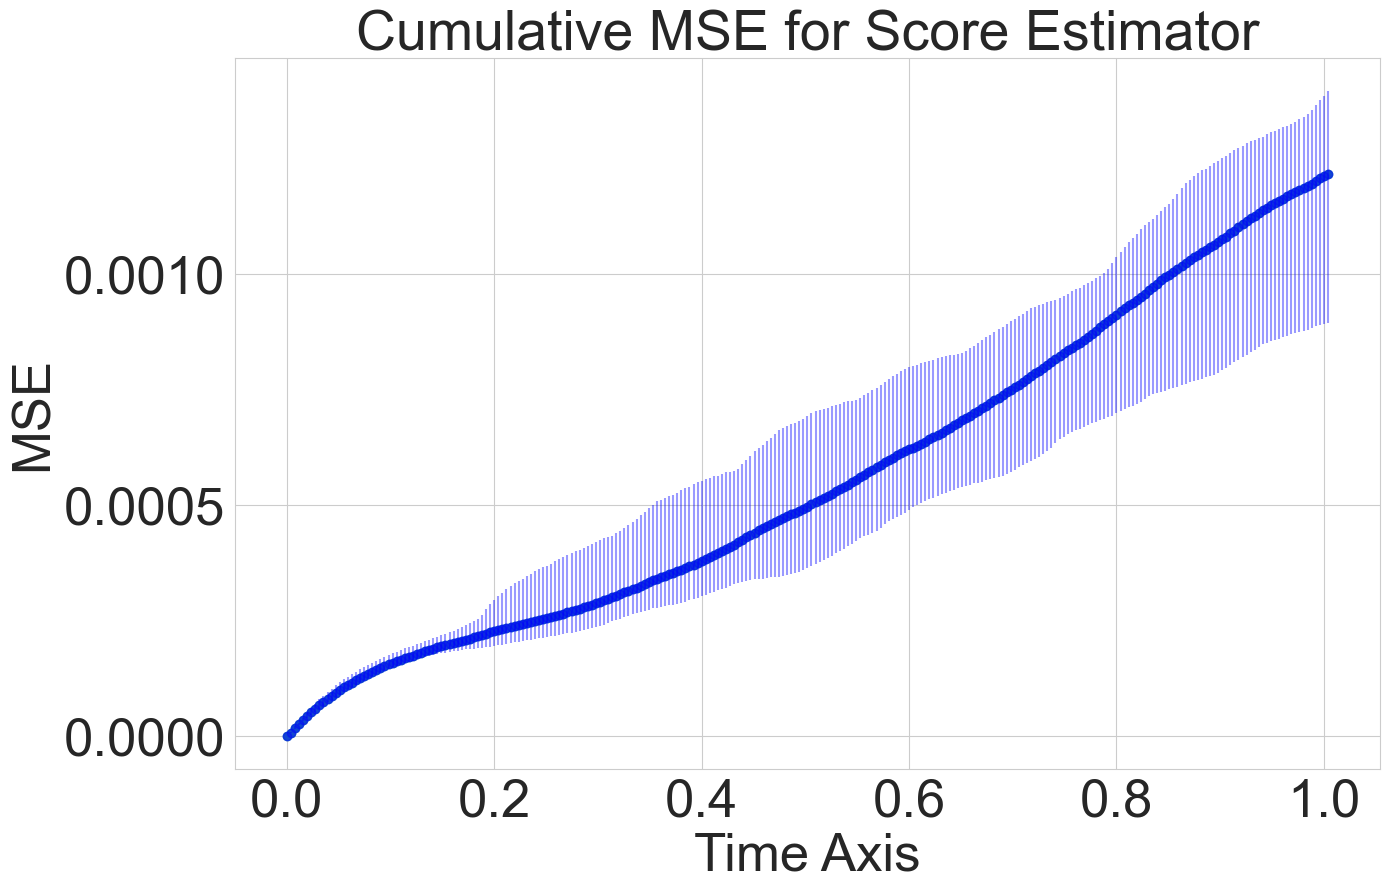

Final time cumulative MSE local-time error 0.0012182793812230601 with IQR ((0.0008952938170676492, 0.001397990242772418))at Nepoch 70

0.0011412450021705428 0.0005219774414654303 0.0012182793812230601 7


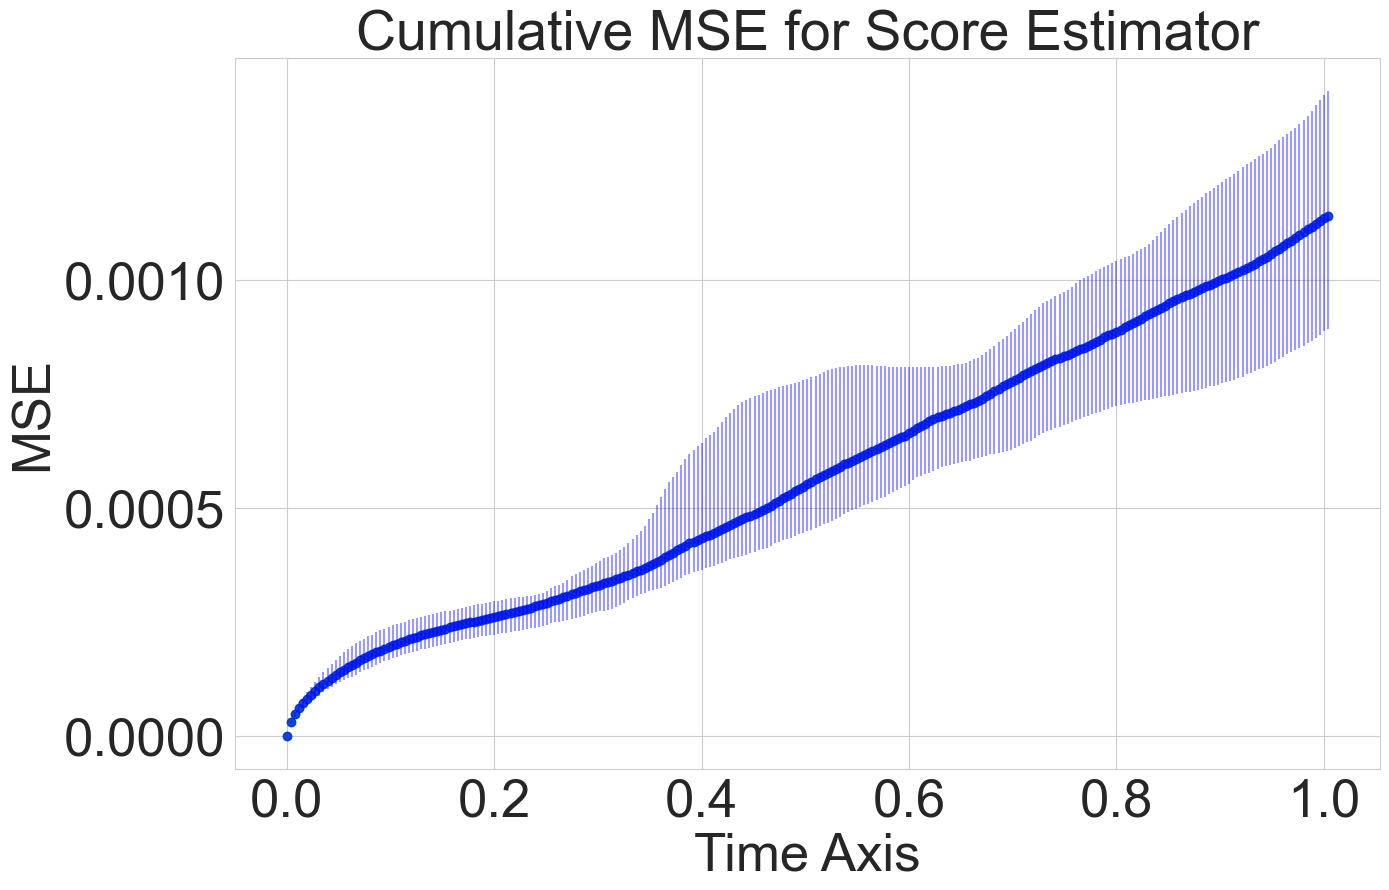

Final time cumulative MSE local-time error 0.0011412450021705428 with IQR ((0.0008933361464774495, 0.0014153135879428798))at Nepoch 74

0.001247064729021907 0.0006625771466293715 0.0011412450021705428 8
252.21259863172773 72.02651972734697 0.0011412450021705428 9
252.11588145281485 71.81483279666836 0.0011412450021705428 10
0.001085135301705759 0.0006124917467321436 0.0011412450021705428 11


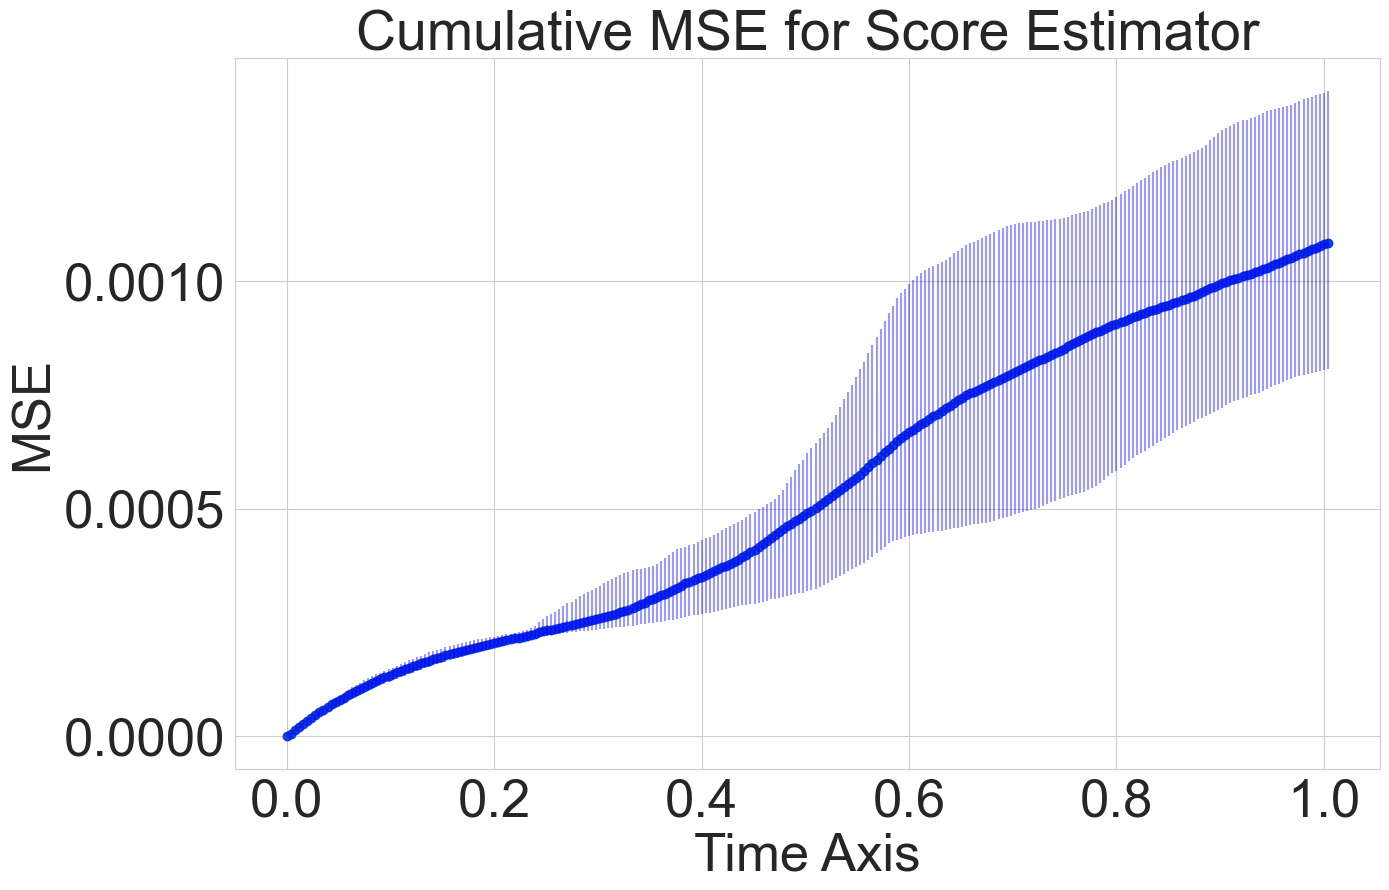

Final time cumulative MSE local-time error 0.001085135301705759 with IQR ((0.0008063545645652378, 0.0014188463112973814))at Nepoch 88

239.15582403745057 72.83200967980451 0.001085135301705759 12
239.10074603874472 72.76059857043705 0.001085135301705759 13
0.0014062857385361025 0.00016829626474578656 0.001085135301705759 14
0.0011703700190446322 0.0006156381049716028 0.001085135301705759 15
0.001067364451390418 0.0006914783832100331 0.001085135301705759 16


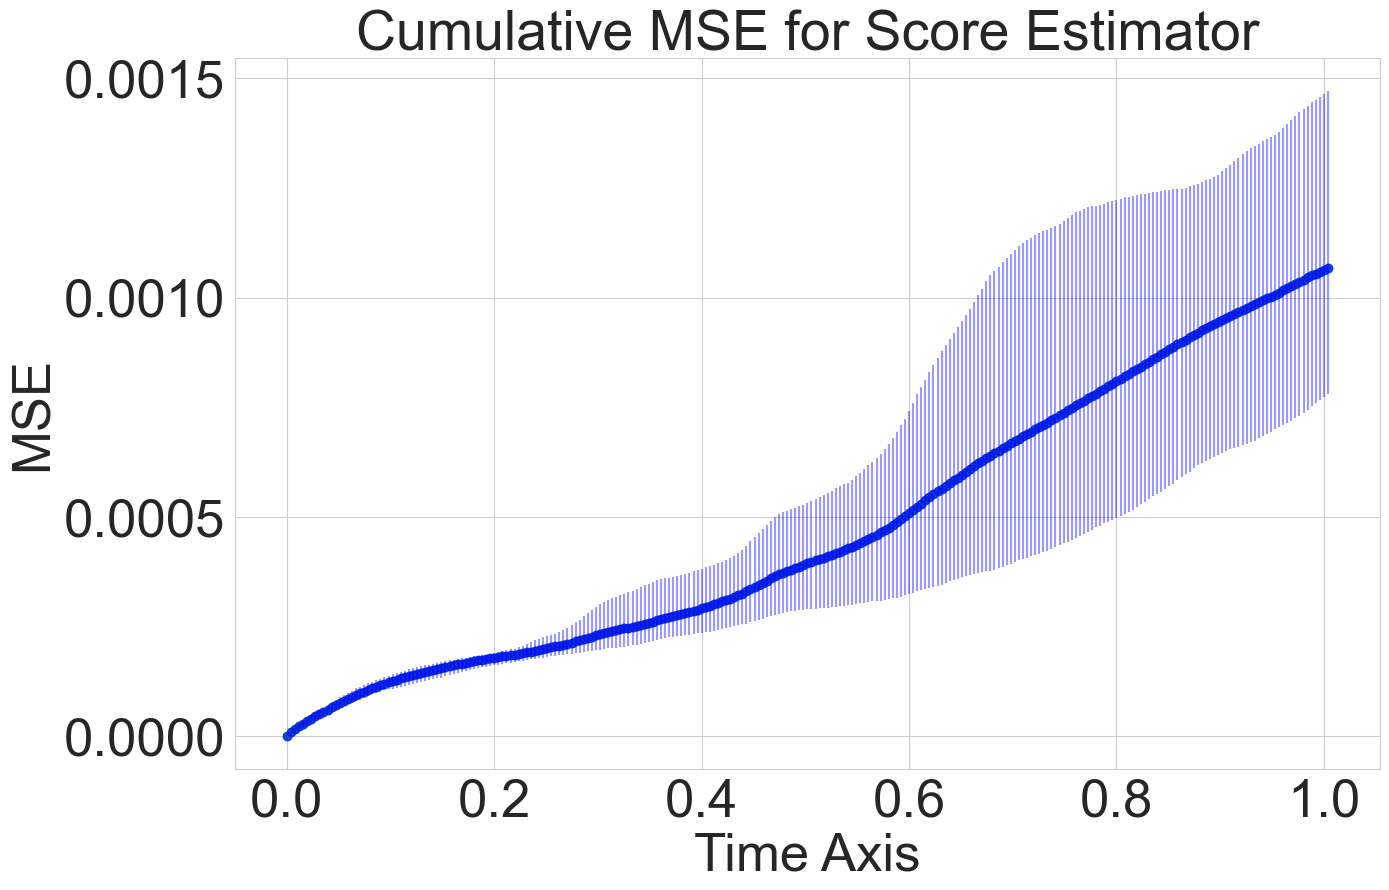

Final time cumulative MSE local-time error 0.001067364451390418 with IQR ((0.0007801214105511388, 0.001471599793761172))at Nepoch 104

0.0014587449140273123 0.001022845087745703 0.001067364451390418 17
248.91336506763955 67.941518203275 0.001067364451390418 18
248.9325198397434 67.90175668284238 0.001067364451390418 19
231.5628678304106 57.361550188424644 0.001067364451390418 20
231.53369724927742 57.1952949583241 0.001067364451390418 21
0.0011993072031319192 0.0007760603979081137 0.001067364451390418 22
0.0004795939497837153 0.0004537852626817035 0.001067364451390418 23


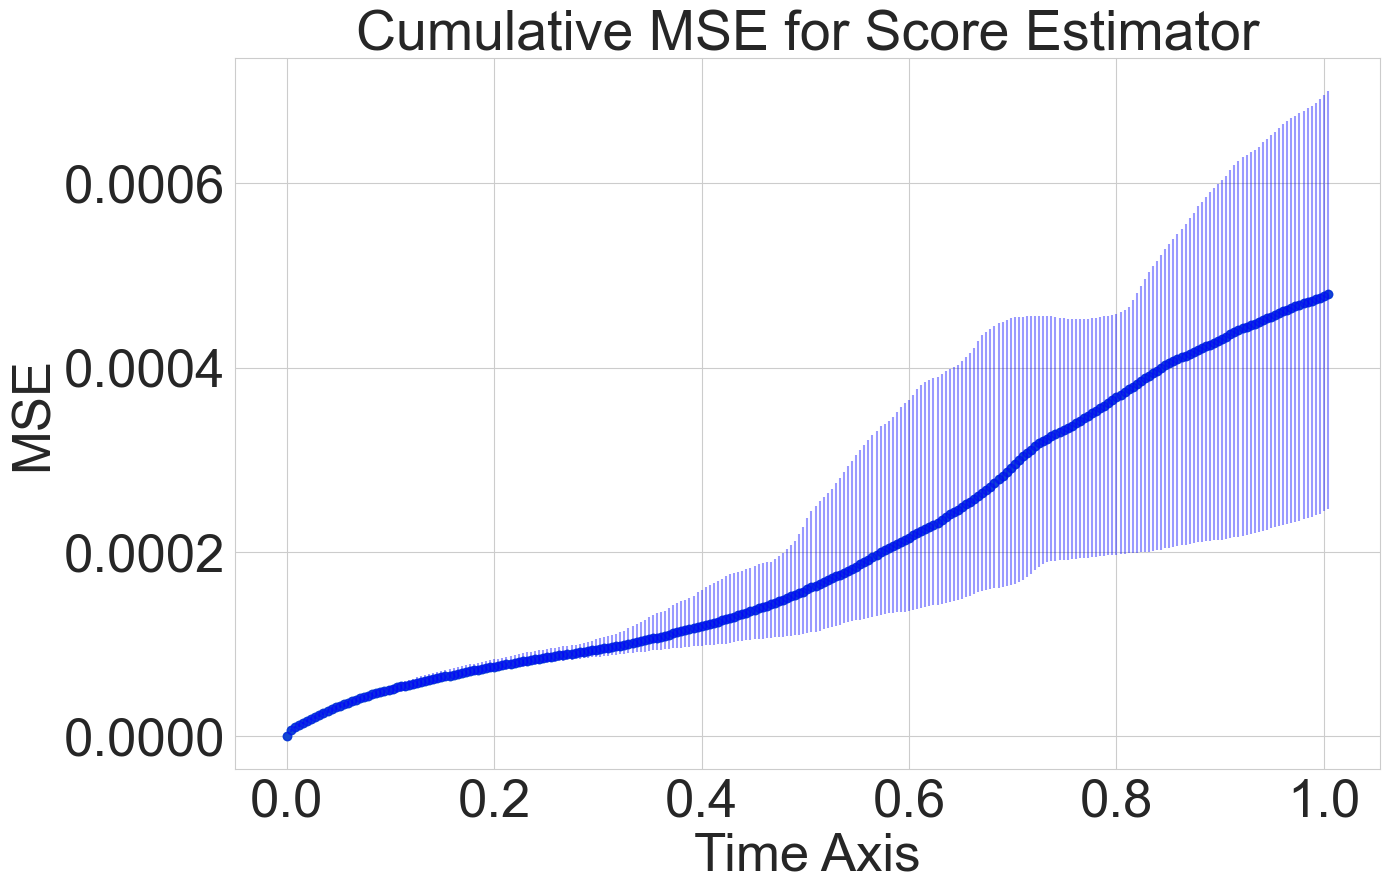

Final time cumulative MSE local-time error 0.0004795939497837153 with IQR ((0.0002469268749294084, 0.0007007121376111119))at Nepoch 128

0.0011335056961744006 0.0007563351354417678 0.0004795939497837153 24
0.0002820442674023044 0.00015920955297415648 0.0004795939497837153 25


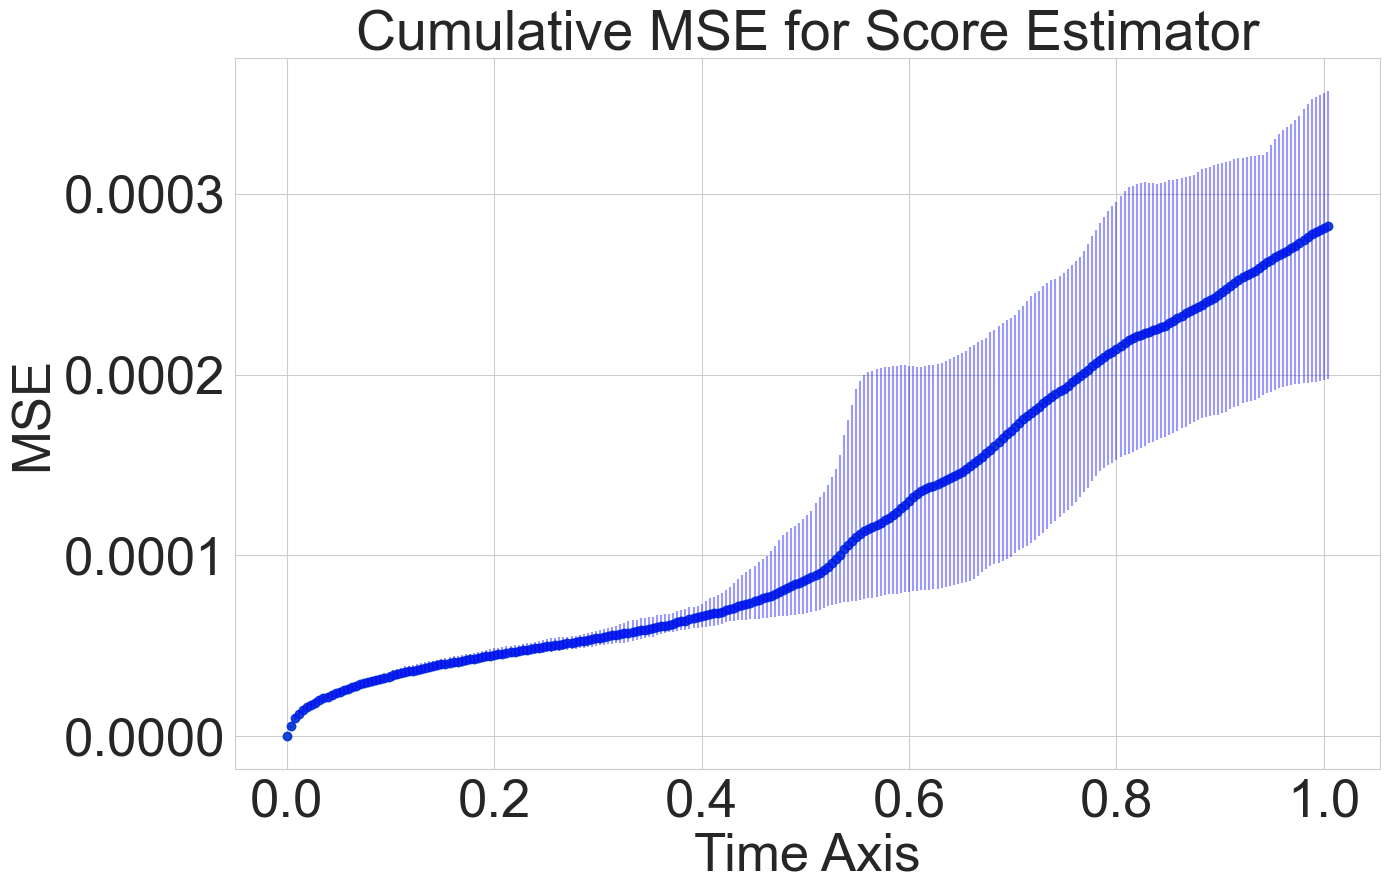

Final time cumulative MSE local-time error 0.0002820442674023044 with IQR ((0.00019766234189858218, 0.00035687189487273866))at Nepoch 134

242.74977143048986 58.26614146698546 0.0002820442674023044 26
242.609448834725 58.28957159237359 0.0002820442674023044 27
235.4346357985646 58.09361636739567 0.0002820442674023044 28
235.61158458706979 58.10415162002235 0.0002820442674023044 29
0.00012148409911546978 0.00018623233592341594 0.0002820442674023044 30


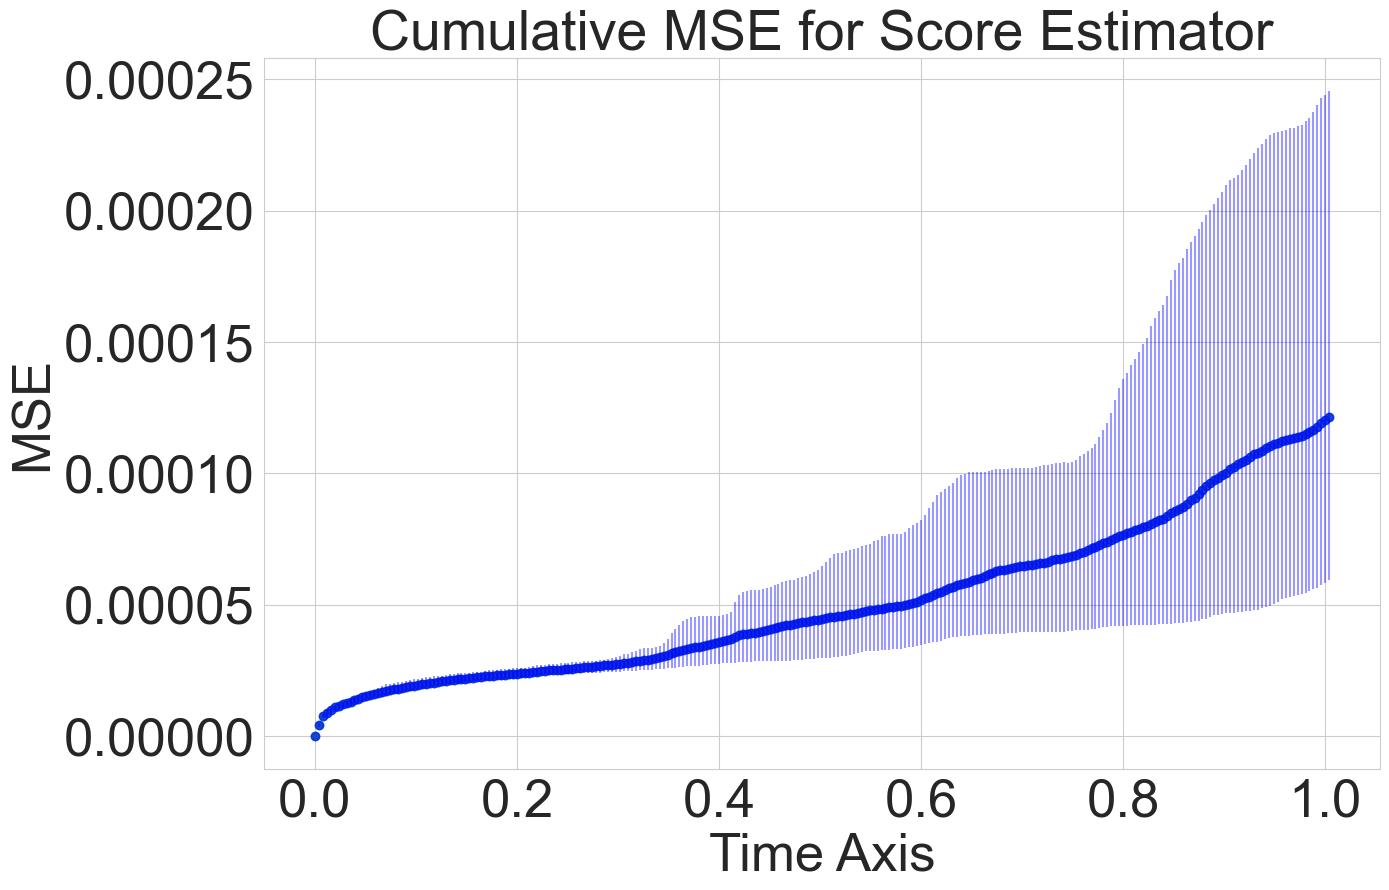

Final time cumulative MSE local-time error 0.00012148409911546978 with IQR ((5.93845654441465e-05, 0.00024561690136756245))at Nepoch 150

0.0009482683553982843 0.0007101462229048848 0.00012148409911546978 31
233.81911590475838 40.34409928005587 0.00012148409911546978 32
234.0252549239695 40.41541820758667 0.00012148409911546978 33
0.00016773619554356147 0.00013845478011098144 0.00012148409911546978 34
0.0008143257808491738 0.0005487054592840963 0.00012148409911546978 35
0.0006106011683913507 0.0004640708116295388 0.00012148409911546978 36
0.00021997289215350166 9.558567773791215e-05 0.00012148409911546978 37
252.40314837579837 58.70335764030409 0.00012148409911546978 38
252.2072283154138 58.70189327502979 0.00012148409911546978 39
240.02797186395514 48.95452545529483 0.00012148409911546978 40
240.23307989751225 48.96412149917123 0.00012148409911546978 41
0.00012911924731828743 9.597060591991483e-05 0.00012148409911546978 42
0.0003173064751540968 0.00041848437455914574 0.000121484099115

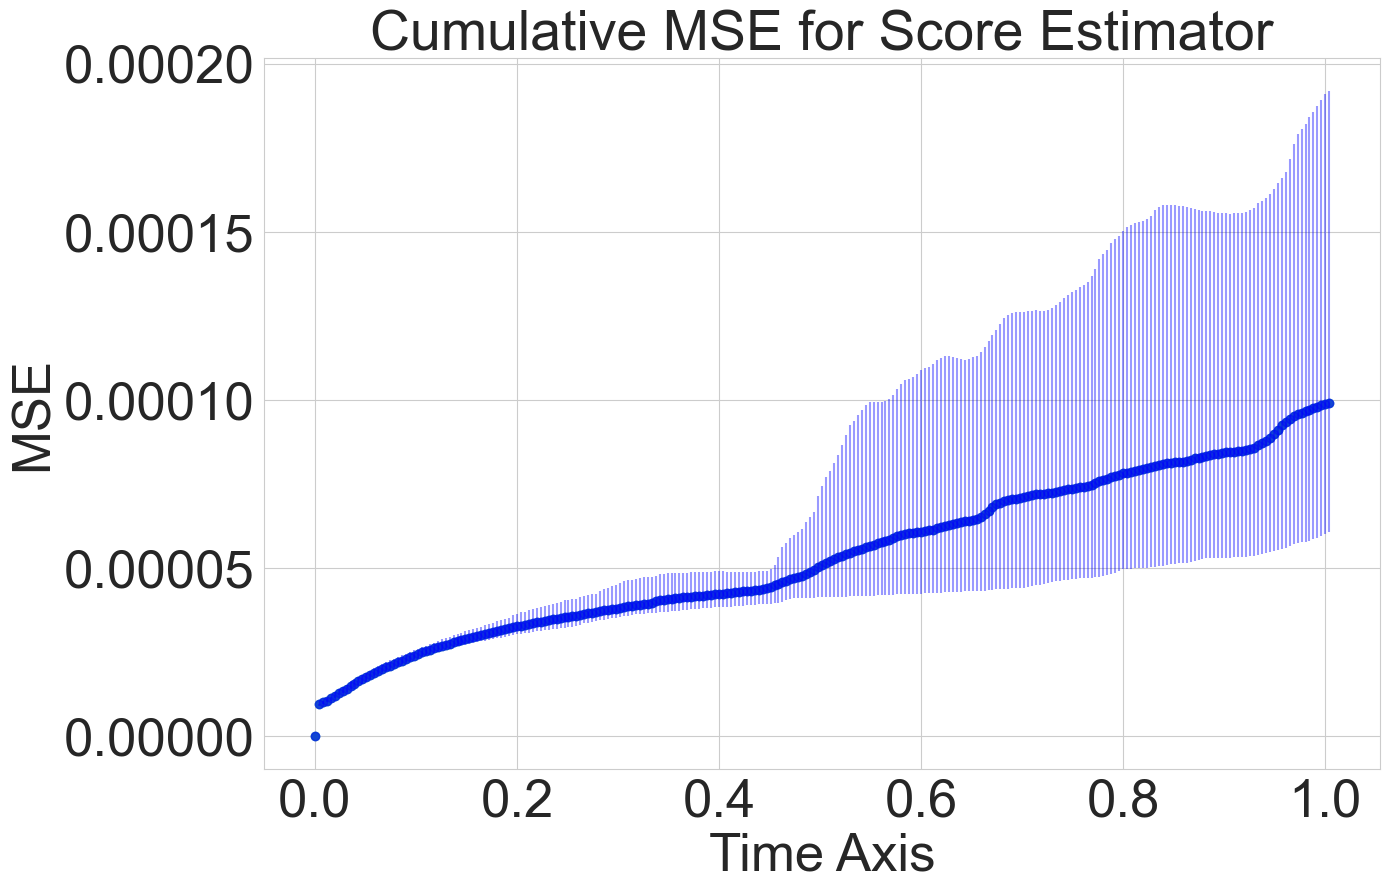

Final time cumulative MSE local-time error 9.922037251973116e-05 with IQR ((6.084747419927202e-05, 0.00019206404434733495))at Nepoch 414

0.00015720377610068222 0.0003316170400506456 9.922037251973116e-05 110
0.00030153594993303096 5.227167866440056e-05 9.922037251973116e-05 111
247.29058308852564 65.57976813675612 9.922037251973116e-05 112
247.2757561616856 65.60754896777402 9.922037251973116e-05 113
0.0002468503848447116 4.6247140429559575e-05 9.922037251973116e-05 114
0.0001940479767211743 5.577230464473532e-05 9.922037251973116e-05 115
0.00013286172234487707 0.0001785132153821508 9.922037251973116e-05 116
247.1548197226985 71.27422821891383 9.922037251973116e-05 117
247.17906711612068 71.39470790824555 9.922037251973116e-05 118
7.215503784370606e-05 5.0784259452927926e-05 9.922037251973116e-05 119


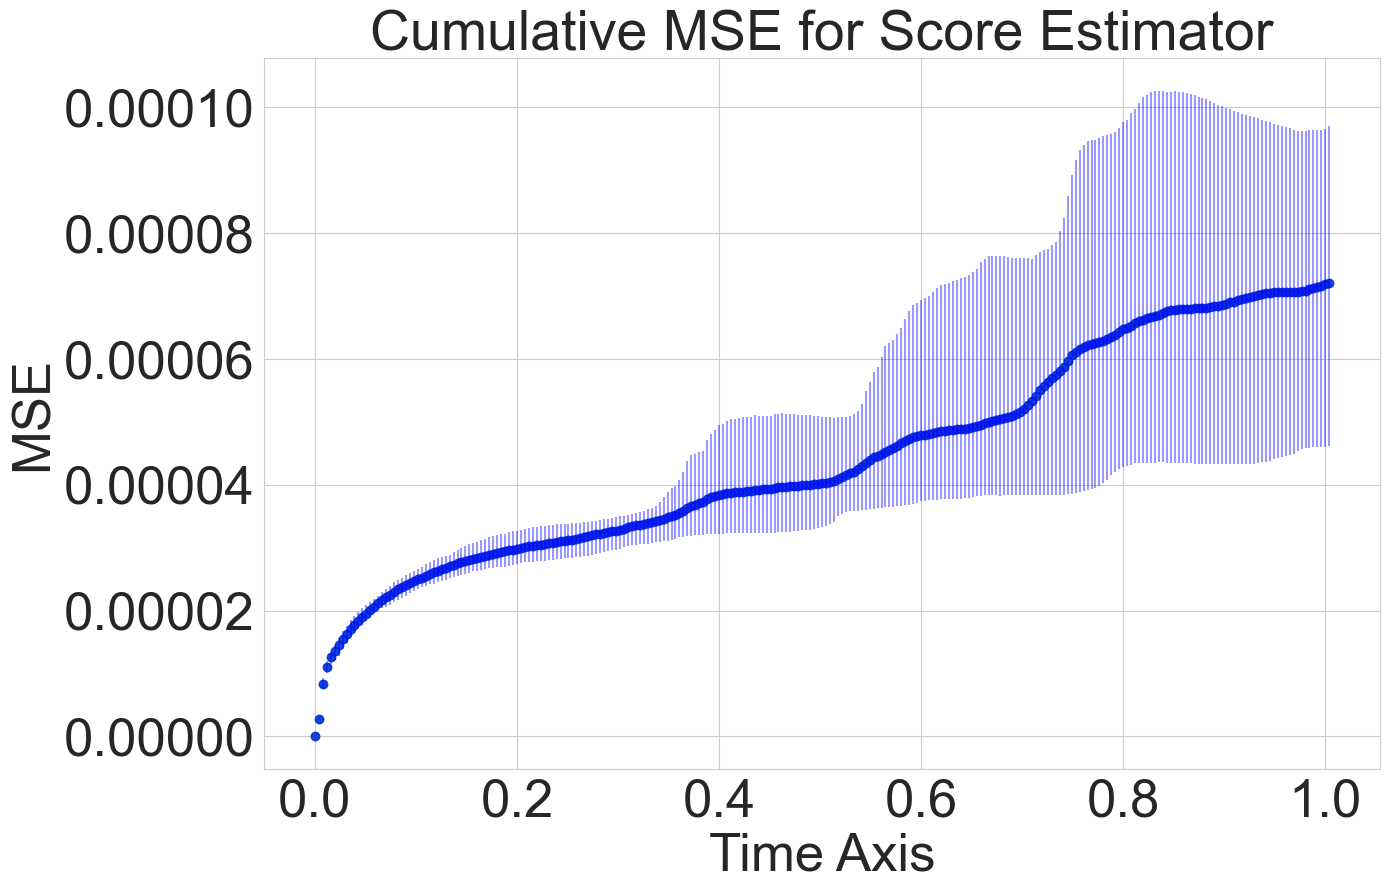

Final time cumulative MSE local-time error 7.215503784370606e-05 with IQR ((4.62550206818624e-05, 9.703928013479033e-05))at Nepoch 448

0.0001466227590865263 6.923288705927489e-05 7.215503784370606e-05 120
0.0001762930741465622 0.0002492382086933532 7.215503784370606e-05 121
242.1719296333218 74.97231789646483 7.215503784370606e-05 122
242.20268344854858 74.97835707845178 7.215503784370606e-05 123
0.0001381872586214704 0.00010212407611845263 7.215503784370606e-05 124
0.00014577330288125946 0.00013308256460616198 7.215503784370606e-05 125
9.549241945923868e-05 7.409270455429631e-05 7.215503784370606e-05 126
245.02890176877017 74.04717798774632 7.215503784370606e-05 127
245.00756261140623 74.13607681610344 7.215503784370606e-05 128
0.00045210527780602277 9.459271453909657e-05 7.215503784370606e-05 129
245.48462545475323 78.62104596372177 7.215503784370606e-05 130
245.44302750377005 78.6324981181732 7.215503784370606e-05 131
0.00025022729785337955 0.00017801283923606583 7.215503784370606e

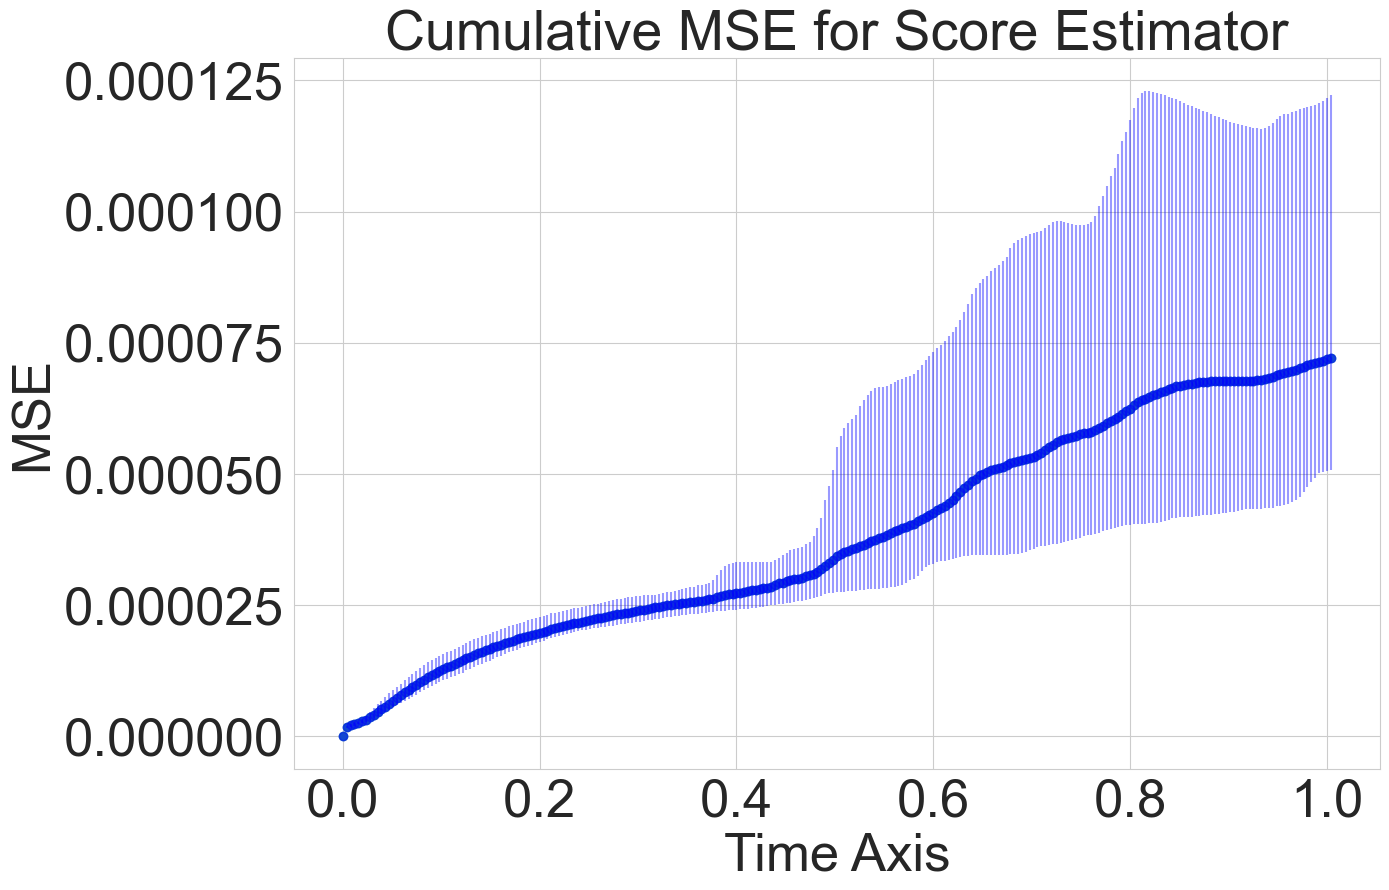

Final time cumulative MSE local-time error 7.21425005234128e-05 with IQR ((5.080682556107376e-05, 0.00012224466798729732))at Nepoch 574

0.0002862407371437733 4.845191167339002e-05 7.21425005234128e-05 158
0.00012224662658827715 7.639660648799662e-05 7.21425005234128e-05 159
237.8807112058377 73.361775020028 7.21425005234128e-05 160
237.86167308572075 73.34605369647645 7.21425005234128e-05 161
9.642278271148618e-05 8.633331017871008e-05 7.21425005234128e-05 162
0.0001928841375878333 6.770506850103995e-05 7.21425005234128e-05 163
0.0001229338959782079 6.870799044750781e-05 7.21425005234128e-05 164
248.0719241995709 72.24785854783408 7.21425005234128e-05 165
248.12072335136594 72.27943164185515 7.21425005234128e-05 166
0.0007400847207647273 3.262576206465497e-05 7.21425005234128e-05 167
8.200539635824749e-05 4.4774446577993594e-05 7.21425005234128e-05 168
0.00020170651474539996 0.00012709357533832215 7.21425005234128e-05 169
230.03847485776413 67.47188031505198 7.21425005234128e-05 170
2

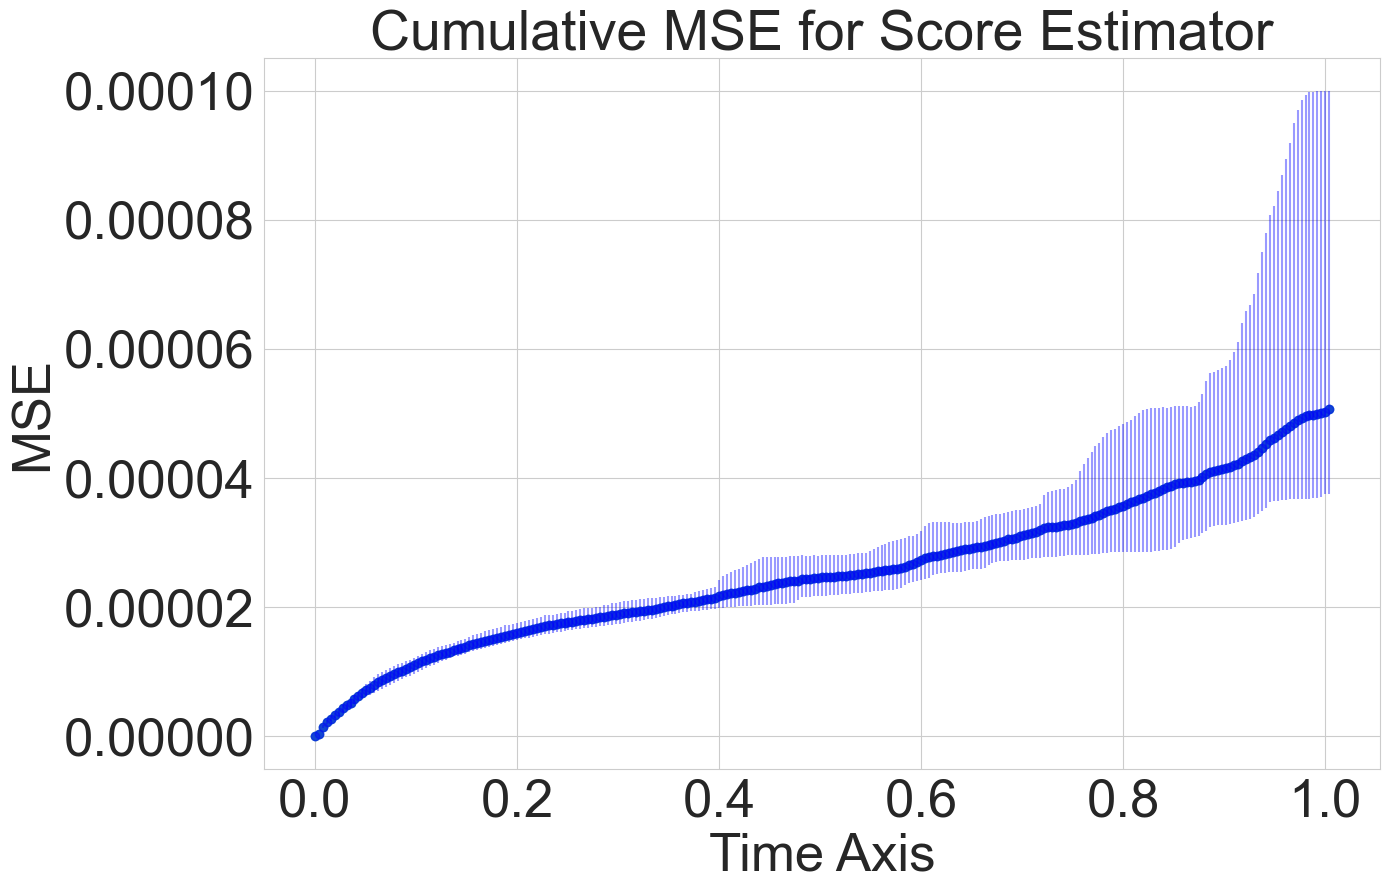

Final time cumulative MSE local-time error 5.063602785620666e-05 with IQR ((3.755658039732169e-05, 0.00010000021965090061))at Nepoch 644

0.00017745788617987604 6.522031256934853e-05 5.063602785620666e-05 179
8.171910021634117e-05 8.333747660926654e-05 5.063602785620666e-05 180
0.0002883676297874504 7.465720169476695e-05 5.063602785620666e-05 181
247.82160007962625 81.45970708539684 5.063602785620666e-05 182
247.80091073004792 81.45767798001924 5.063602785620666e-05 183
9.806676354231642e-05 5.535237355075365e-05 5.063602785620666e-05 184
0.0002715872021720496 7.644843933095341e-05 5.063602785620666e-05 185
231.54008345325488 68.31948660640867 5.063602785620666e-05 186
231.50358180067286 68.35076287104323 5.063602785620666e-05 187
253.9017539312171 90.0859197229804 5.063602785620666e-05 188
253.9771849832664 90.08720547485422 5.063602785620666e-05 189
4.4765584122335214e-05 5.599219812315699e-05 5.063602785620666e-05 190


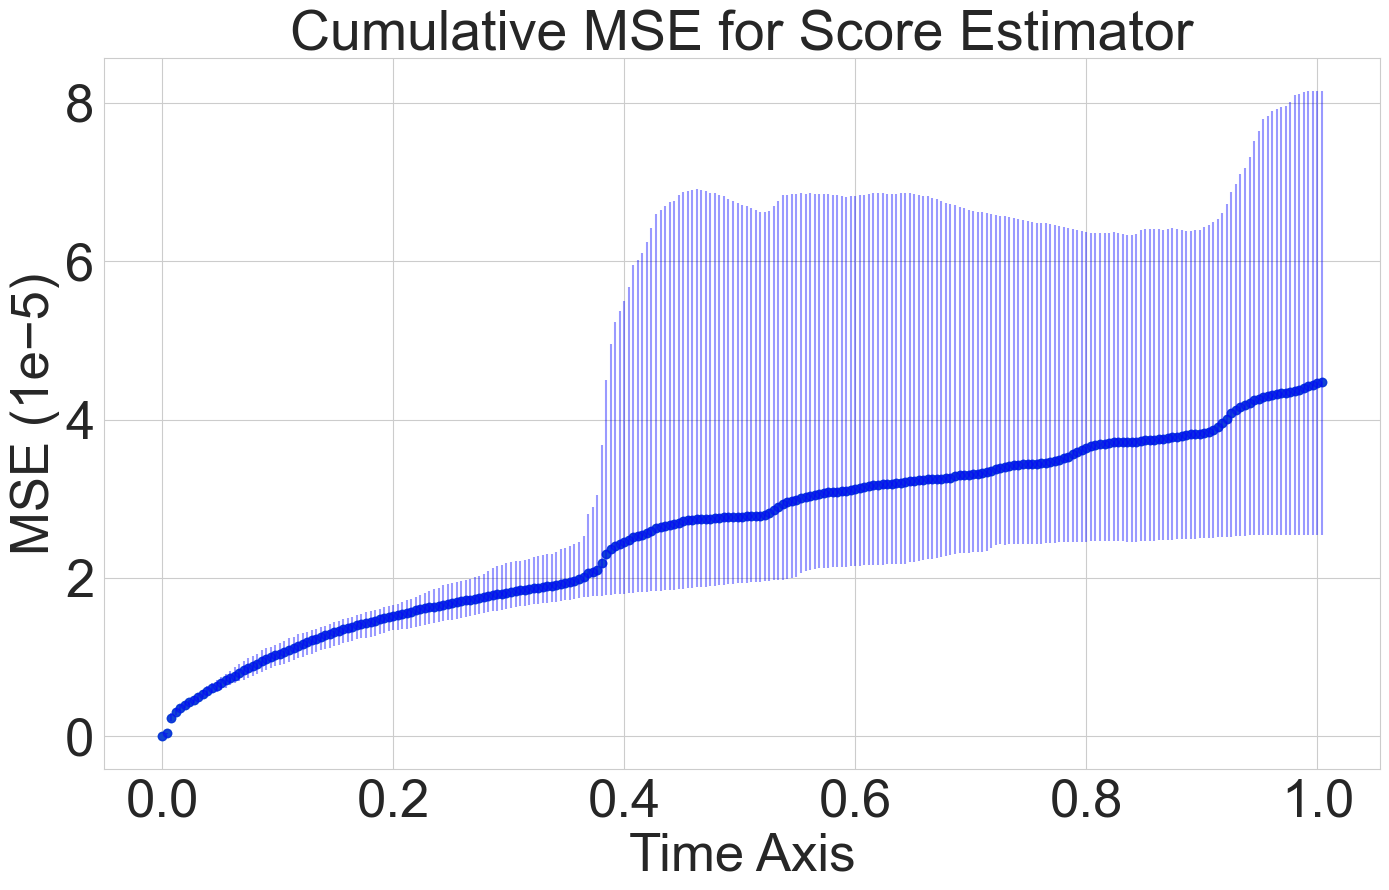

Final time cumulative MSE local-time error 4.4765584122335214e-05 with IQR ((2.5479097221448422e-05, 8.147129534460541e-05))at Nepoch 684

8.765159534086847e-05 0.00011731236712316003 4.4765584122335214e-05 191
239.39597261508757 48.7732440883685 4.4765584122335214e-05 192
239.33498246477993 48.7342892206853 4.4765584122335214e-05 193
0.00011921021084641459 7.835327546322619e-05 4.4765584122335214e-05 194
0.00017234949400739657 4.7760688903145186e-05 4.4765584122335214e-05 195
248.71400827228314 68.89984733882062 4.4765584122335214e-05 196
248.6680266388599 68.88865450544435 4.4765584122335214e-05 197
0.0001334044306753335 0.00010213042845514009 4.4765584122335214e-05 198
0.00034536623265492527 7.517571297126457e-05 4.4765584122335214e-05 199
238.683084383007 86.26756654727848 4.4765584122335214e-05 200
238.69692348710427 86.26917269954814 4.4765584122335214e-05 201
0.0009498522707130708 4.8003085813534685e-05 4.4765584122335214e-05 202
7.812322324866684e-05 5.210129892056111e-05 4.476

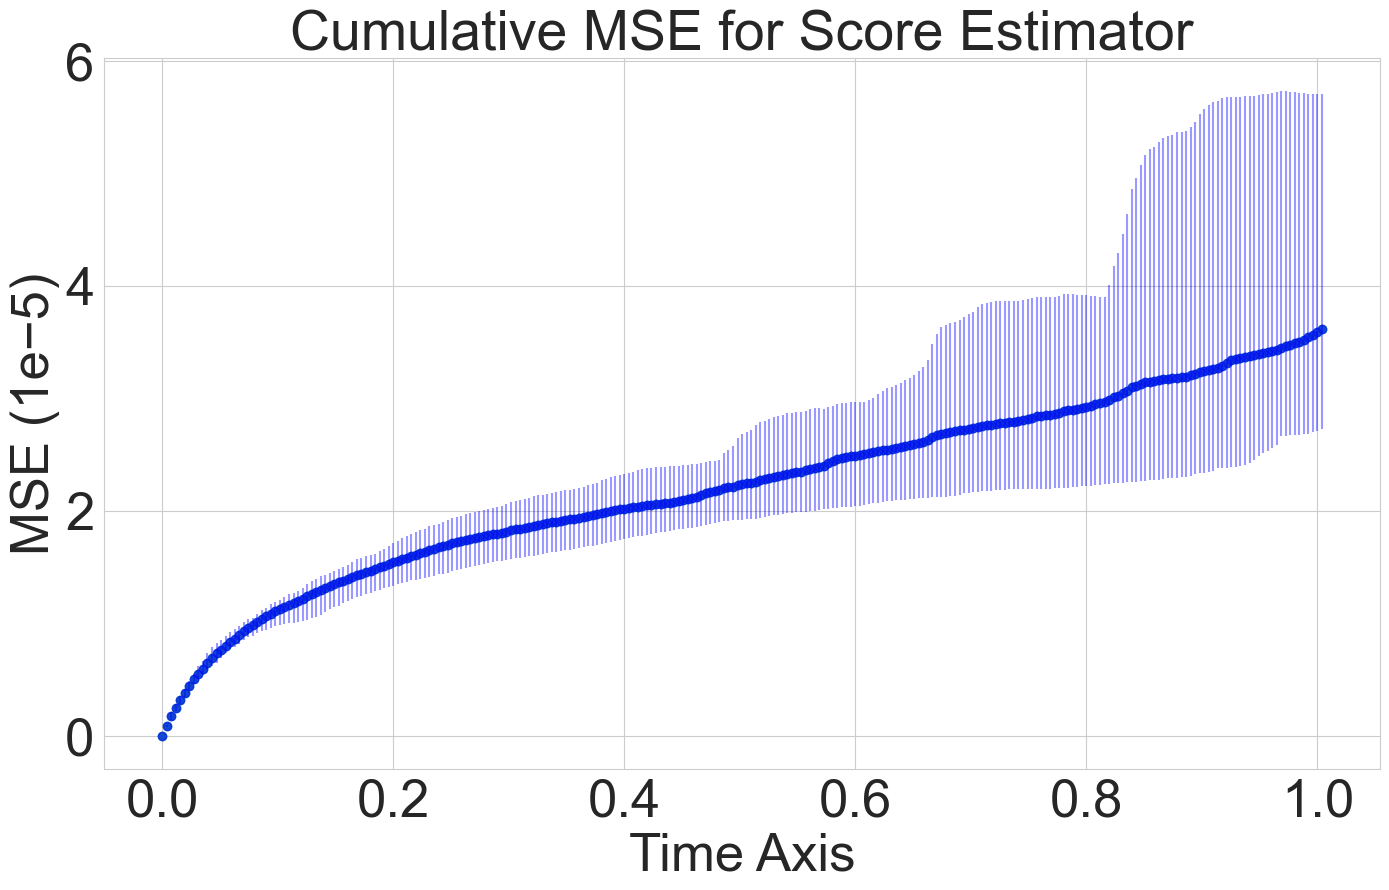

Final time cumulative MSE local-time error 3.618481331420221e-05 with IQR ((2.7293057552774898e-05, 5.708455744623551e-05))at Nepoch 778

8.350190164387451e-05 8.96657211667704e-05 3.618481331420221e-05 219
0.0005318603283871975 6.621175993293423e-05 3.618481331420221e-05 220
5.6260977928560525e-05 4.444887337523813e-05 3.618481331420221e-05 221
244.0424129011857 36.87110787390179 3.618481331420221e-05 222
244.04626590824537 36.929600562659374 3.618481331420221e-05 223
0.0001513816234452304 3.0292959141500666e-05 3.618481331420221e-05 224
0.00023583502585344693 3.180445967126535e-05 3.618481331420221e-05 225
243.72720972320764 55.947158614849855 3.618481331420221e-05 226
243.72846531531073 55.964953130954086 3.618481331420221e-05 227
0.00012867487660862776 3.1721874424228246e-05 3.618481331420221e-05 228
4.923682698382044e-05 5.460966511615254e-05 3.618481331420221e-05 229
236.79119717437712 98.95806895424226 3.618481331420221e-05 230
236.80554261570848 98.94659578407368 3.618481331420

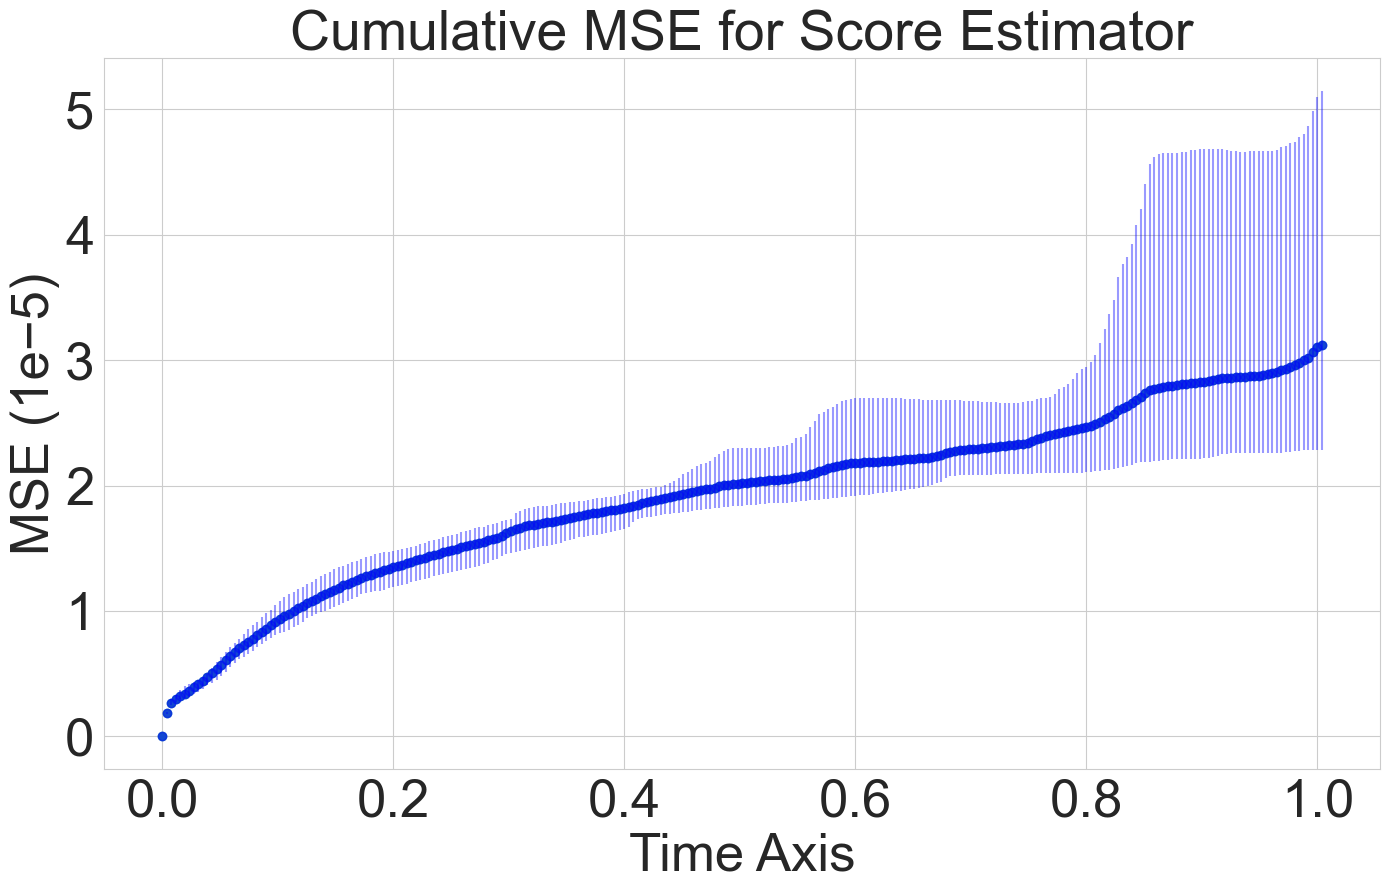

Final time cumulative MSE local-time error 3.1170911287452686e-05 with IQR ((2.2853934019780792e-05, 5.147287700108822e-05))at Nepoch 880

241.6016498002826 45.34022014538505 3.1170911287452686e-05 250
241.58637734219965 45.33169513661372 3.1170911287452686e-05 251
0.00015507758092431803 4.397384040547337e-05 3.1170911287452686e-05 252
3.568676448481273e-05 3.0724963904457024e-05 3.1170911287452686e-05 253
240.14312671304302 50.38476589616366 3.1170911287452686e-05 254
240.16440704442508 50.3265280175074 3.1170911287452686e-05 255
8.163888425184742e-05 2.0995454454528274e-05 3.1170911287452686e-05 256
2.0595945059429394e-05 3.122072870548072e-05 3.1170911287452686e-05 257


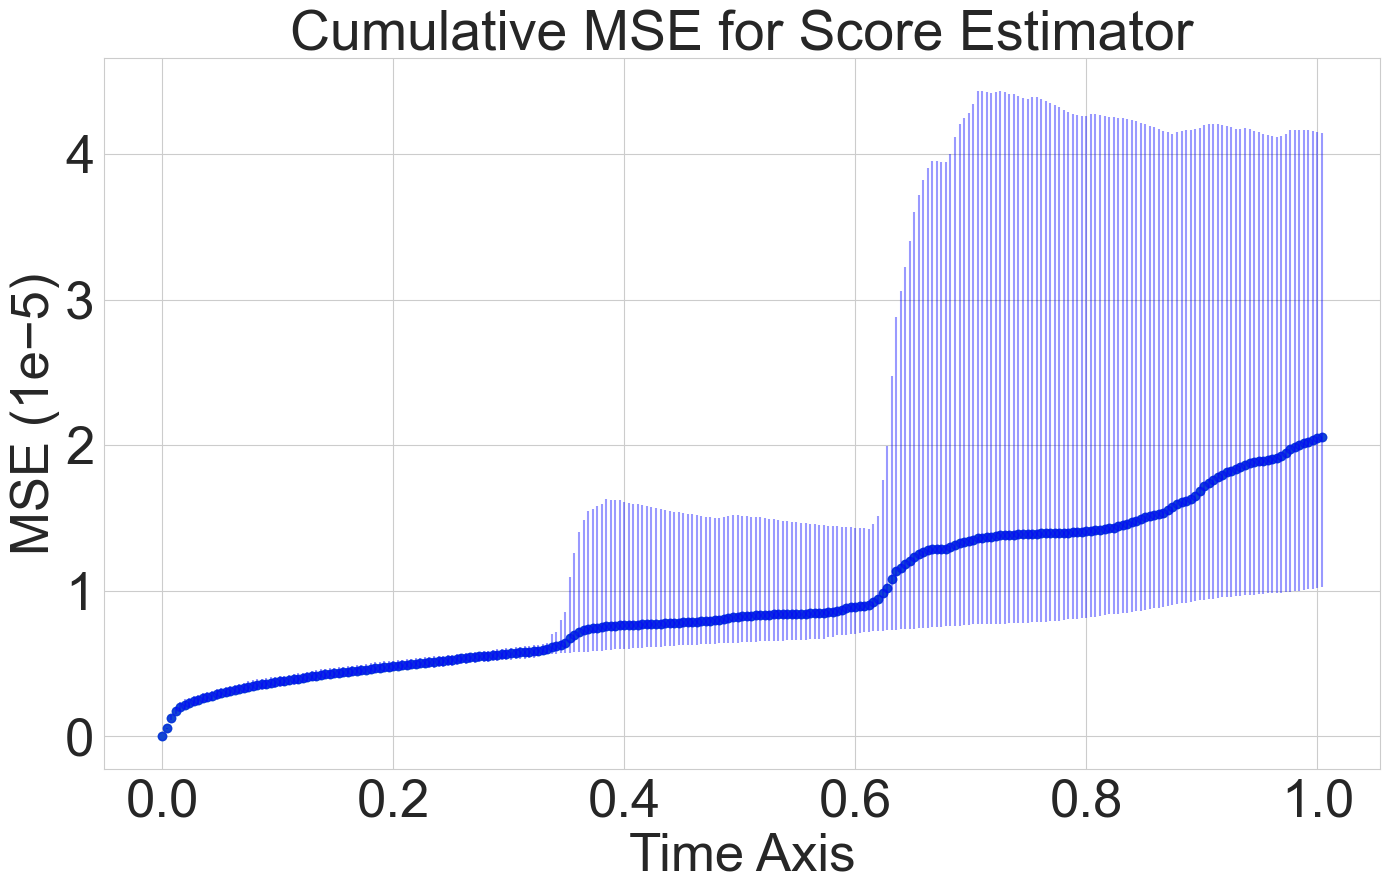

Final time cumulative MSE local-time error 2.0595945059429394e-05 with IQR ((1.026011239606236e-05, 4.148084110154308e-05))at Nepoch 908

246.28553994585317 69.65256771677596 2.0595945059429394e-05 258
246.24200137277847 69.64291104783251 2.0595945059429394e-05 259
249.4734034860894 62.67669137524612 2.0595945059429394e-05 260
249.49437270147763 62.69426454082961 2.0595945059429394e-05 261
7.190860474716084e-05 2.219319001994743e-05 2.0595945059429394e-05 262
3.388899302833636e-05 1.216950353506717e-05 2.0595945059429394e-05 263
243.10112770986092 46.75809717577968 2.0595945059429394e-05 264
243.05691887198554 46.808217411960015 2.0595945059429394e-05 265
4.0160414949826075e-05 2.797241588718329e-05 2.0595945059429394e-05 266
0.0010194576675004769 5.55148276972534e-05 2.0595945059429394e-05 267
242.50537315670408 53.114221625951956 2.0595945059429394e-05 268
242.52028128251337 53.114895111890576 2.0595945059429394e-05 269
4.2869253751142554e-05 3.9766049249458866e-05 2.0595945059429394

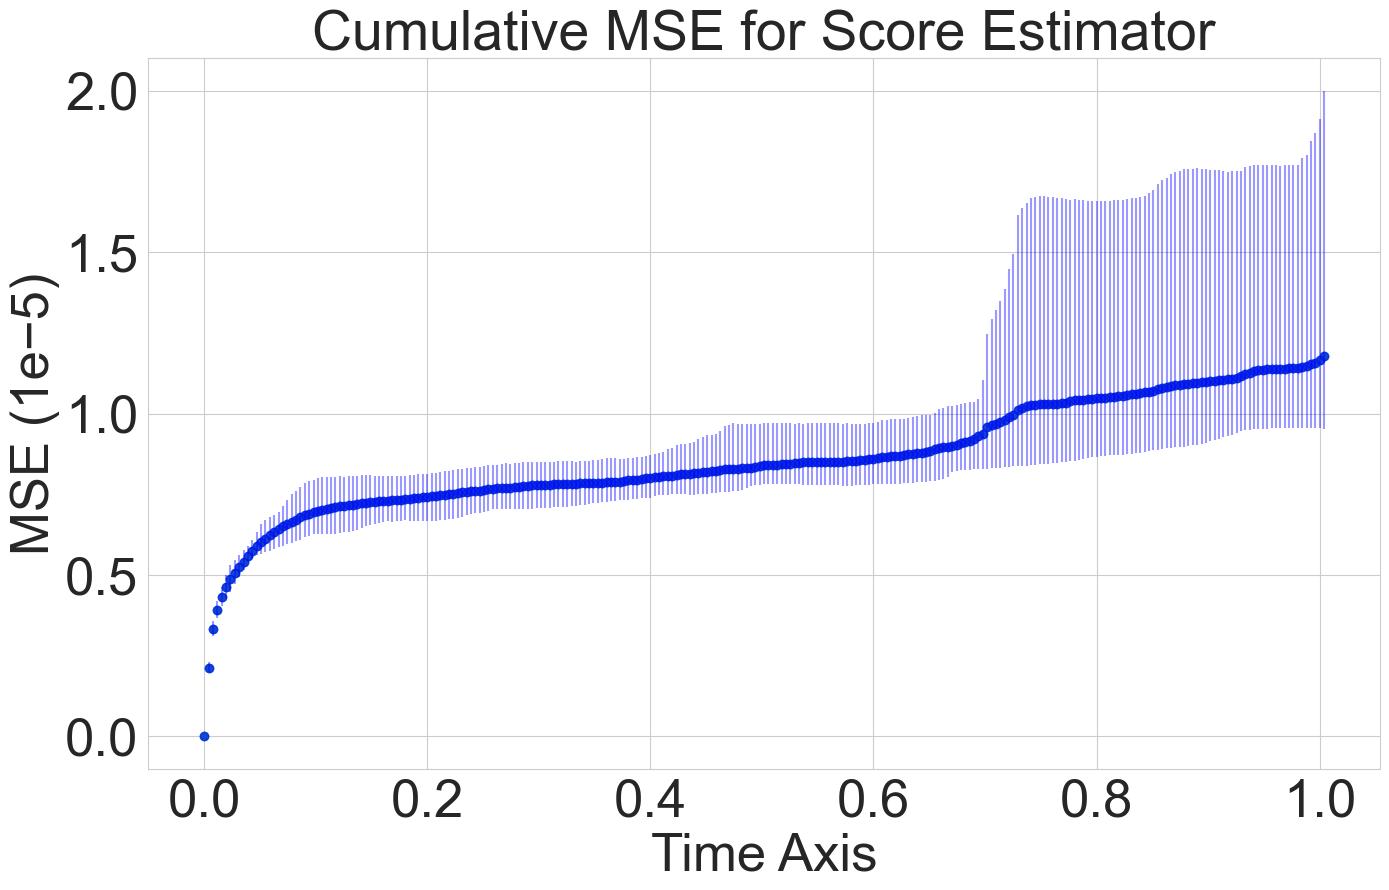

Final time cumulative MSE local-time error 1.1797991236052273e-05 with IQR ((9.538606710944299e-06, 2.000488586332627e-05))at Nepoch 1050

3.018259874194371e-05 1.8426157277684446e-05 1.1797991236052273e-05 301
230.81284775617945 72.00219358164443 1.1797991236052273e-05 302
230.82185842100017 72.0376335699813 1.1797991236052273e-05 303
0.00010044945661582779 7.865226090944191e-05 1.1797991236052273e-05 304
2.655570542797274e-05 1.0755463683665633e-05 1.1797991236052273e-05 305
240.28901330631192 62.48794950424016 1.1797991236052273e-05 306
240.33159644857992 62.41159142689628 1.1797991236052273e-05 307
2.4239254337774328e-05 2.9140864071122384e-05 1.1797991236052273e-05 308
4.011741983760132e-05 0.00011507603244474953 1.1797991236052273e-05 309
251.96734859233985 77.15056452548365 1.1797991236052273e-05 310
252.0030080271434 77.08458521429952 1.1797991236052273e-05 311
4.869526181518831e-05 1.453638234964567e-05 1.1797991236052273e-05 312
0.00018357704203717805 3.8477019805507174e-05 1

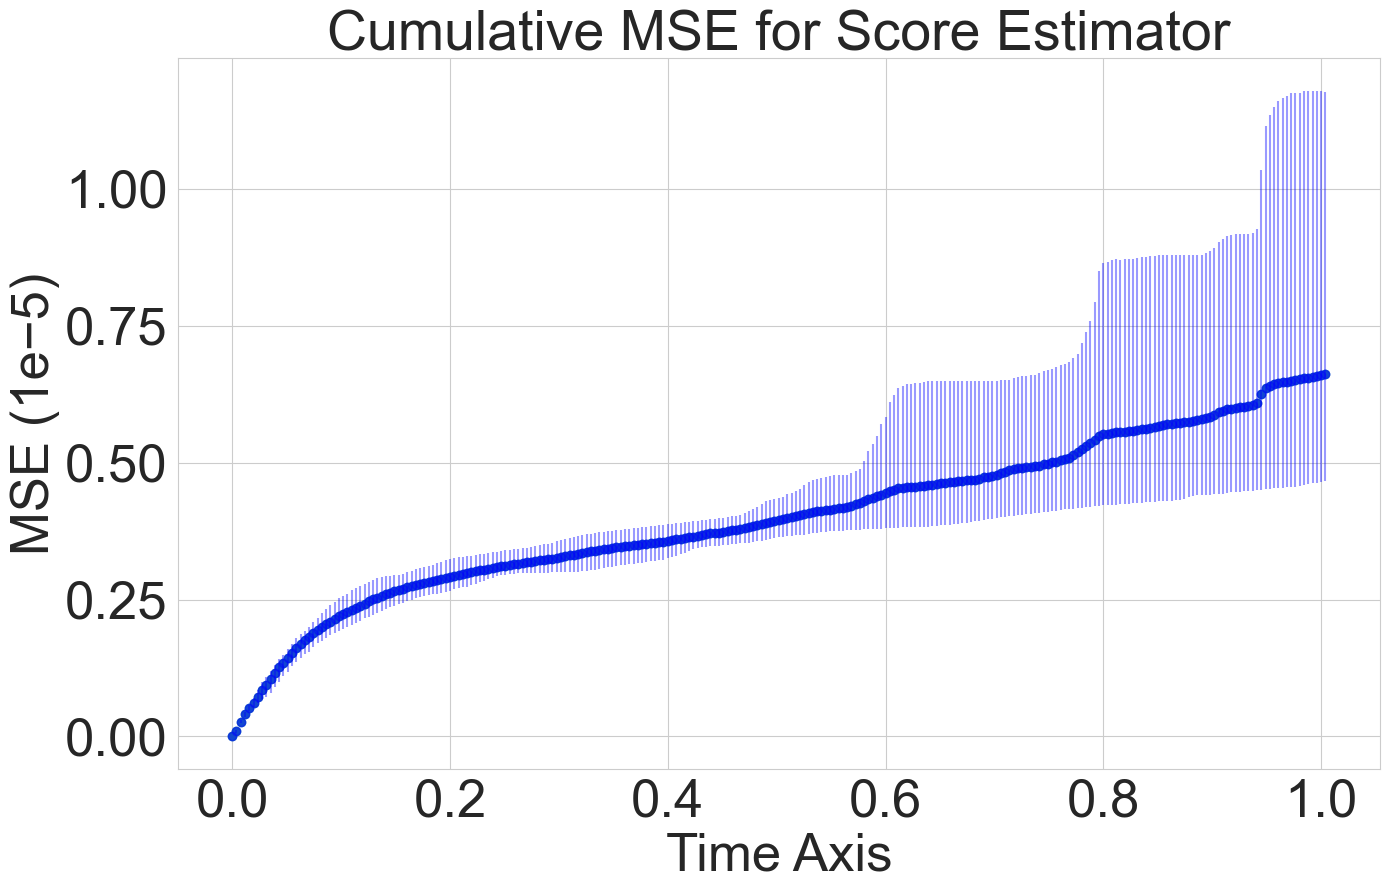

Final time cumulative MSE local-time error 6.615556403735334e-06 with IQR ((4.663039098869303e-06, 1.1775319919113096e-05))at Nepoch 1280

250.10752991377694 88.99113164637555 6.615556403735334e-06 370
250.09047668304115 88.99611569788314 6.615556403735334e-06 371
7.850187481258133e-05 2.203234683936106e-05 6.615556403735334e-06 372
0.00013416912390834898 1.921105518130377e-05 6.615556403735334e-06 373
244.03789866193023 91.13480851452988 6.615556403735334e-06 374
244.00434747906988 91.13695730775544 6.615556403735334e-06 375
2.6006299183208682e-05 4.831933510866889e-06 6.615556403735334e-06 376
6.524901122125678e-05 1.5582814765256376e-05 6.615556403735334e-06 377
242.2515900304621 47.02295340233482 6.615556403735334e-06 378
242.2846528954348 47.011020266390005 6.615556403735334e-06 379
238.50528791474835 67.19414712903608 6.615556403735334e-06 380
238.55086613837835 67.20022797799689 6.615556403735334e-06 381
3.614658385027004e-05 1.0562942904952256e-05 6.615556403735334e-06 382
2.70

In [69]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if i == 1: continue
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Score Estimator",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'MSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('MSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                if "ST" in config.scoreNet_trained_path:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
                else:
                     plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")